# Using *ceffyl* on a PTA free spectrum

A free spectrum of the PTA is easy to refit spectra using *ceffyl*. Simply choose your spectrum from *ceffyl.model* (or create your own function!), along with the number of frequencies that you want to search over, and let your MCMC run!

First off, let's import some required packages...

In [1]:
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format ='retina'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from chainconsumer.chainconsumer import ChainConsumer
from ceffyl import Ceffyl, models, Sampler
from enterprise.signals import parameter
import ultranest

import la_forge.core as co
import la_forge.diagnostics as dg

## PTA free spectrum

The free spectrum is a model-independent analysis of the timing residuals from the PTA [(Lentati et. al. 2013)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.87.104021). For a PTA free spectrum, we typically model 30 frequency power-laws for each pulsar's intrinsic red noise, as well as a common free-spectrum process instead of an e.g power-law common process. We recover posteriors at each sampled GW frequency that represents the common process' cross-power spectrum at that frequency bin. The posteriors are represented by the coefficient $\rho$, where $$\rho(f_k) = \prod_{a,b}\frac{\Gamma_{ab}S_{ab}(f_k)}{T} = \prod_a\frac{S_{aa}(f_k)}{T}$$ for a pulsar $a$ at a frequency bin $f_k$ for $k \in [1, N_k]$, $S$ is the timing-residual cross-power spectrum, $T$ is the PTA timing baseline, and $\Gamma_{ab}=\delta_{ab}$ is the overlap reduction function between pulsars $a$ and $b$, which we assume to be independent, hence the Dirac delta function.

We run the free spectrum with [`enterprise`](https://github.com/nanograv/enterprise). NOTE: `enterprise` defines $\rho$ differently to the above and within the literature, such that $\rho_\mathrm{enterprise}=\sqrt{\rho}$. With this definiton, $\rho_\mathrm{enterprise}$ has units of seconds and represents the timing residual delay.

Let's see what the free spectrum looks like for a simulated pulsar timing array (simulation based on [Pol et. al. 2021](http://dx.doi.org/10.3847/2041-8213/abf2c9))

In [2]:
freespec = co.Core(corepath='../data/sim0/fs10f_real_0.core')

Text(0, 0.5, '$\\log_{10}$ CP delay [s]')

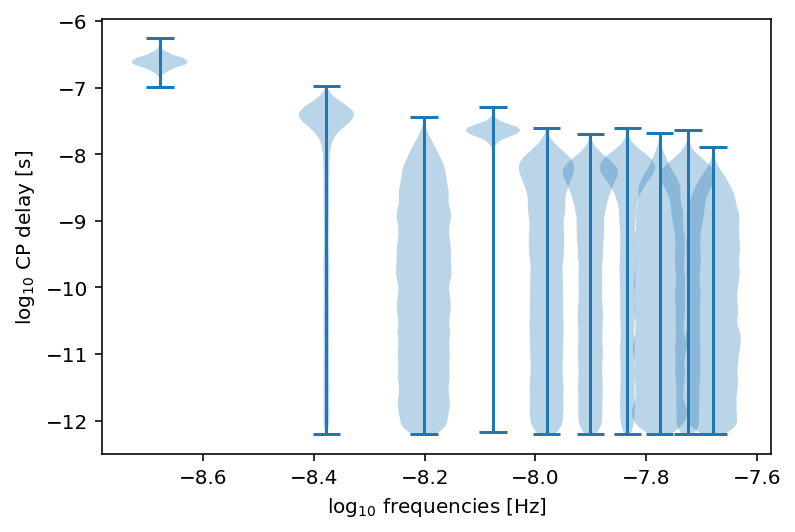

In [3]:
plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-5])),
               positions=np.log10(freespec.rn_freqs),
               widths=0.1)
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')

The injected values for this simulation are:

In [4]:
log10A_inj, gamma_inj = -1.522589999999999932e+01, 4.816799999999999748e+00

## Now let's fit some GW models!

To fit our GW models onto our free spectrum, we must represent our posteriors as probability density functions in order to extract probabilities to build a Bayesian likelihood. Using the most optimal kernel density estimators (KDEs, see paper for details), we can create a grid of probabilities to select from.

For details on creating your own probability grids, see [link to another ipynb being developed]. However, these grids will be made for you in advance for most PTA data sets so all you have to do is use them! :)

let's initialise a Ceffyl object to approximate a PTA using the PTA free spectrum. A directory containing the KDE densities of our simulated PTA free spectrum is our input. It also contains metadata on the frequencies used, pulsar names etc.

In [5]:
pta = Ceffyl.ceffyl(datadir='../data/sim0/fs_densities/')

Define a GW spectrum! Let's try a 5f powerlaw. The default parameters here are $\log_{10}A\in[-18,-12]$, $\gamma\in[0,7]$

In [6]:
gw = Ceffyl.signal(psd=models.powerlaw, N_freqs=10)

Adding signals is easy!

In [7]:
pta.add_signals([gw])

Now let's setup and run our sampler

In [8]:
sampler = Sampler.setup_sampler(pta, 
                                outdir='../data/sim0/refits/10fpl/',
                                logL=pta.ln_likelihood,
                                logp=pta.ln_prior, resume=True)
x0 = pta.initial_samples()  # get initial sample

Adding GWB uniform distribution draws...



In [9]:
sampler.sample(x0, int(200000))  # sample!

/Users/lambwg/Applications/miniconda3/envs/enterprise/lib/python3.9/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 5.00 percent in 2.741399 s Acceptance rate = 0.123222Adding DE jump with weight 20
Finished 99.50 percent in 55.341865 s Acceptance rate = 0.201613
Run Complete


##### Let's read the data

In [10]:
c0 = co.Core('../data/sim0/refits/10fpl/')
c0.set_rn_freqs(Tspan=1/freespec.rn_freqs[0], nfreqs=10)
c0.save('../data/sim0/refits/10fpl/chain.core')
pl10f = co.Core(corepath='../data/sim0/refits/10fpl/chain.core')

checking the traceplot to see if the chains converged

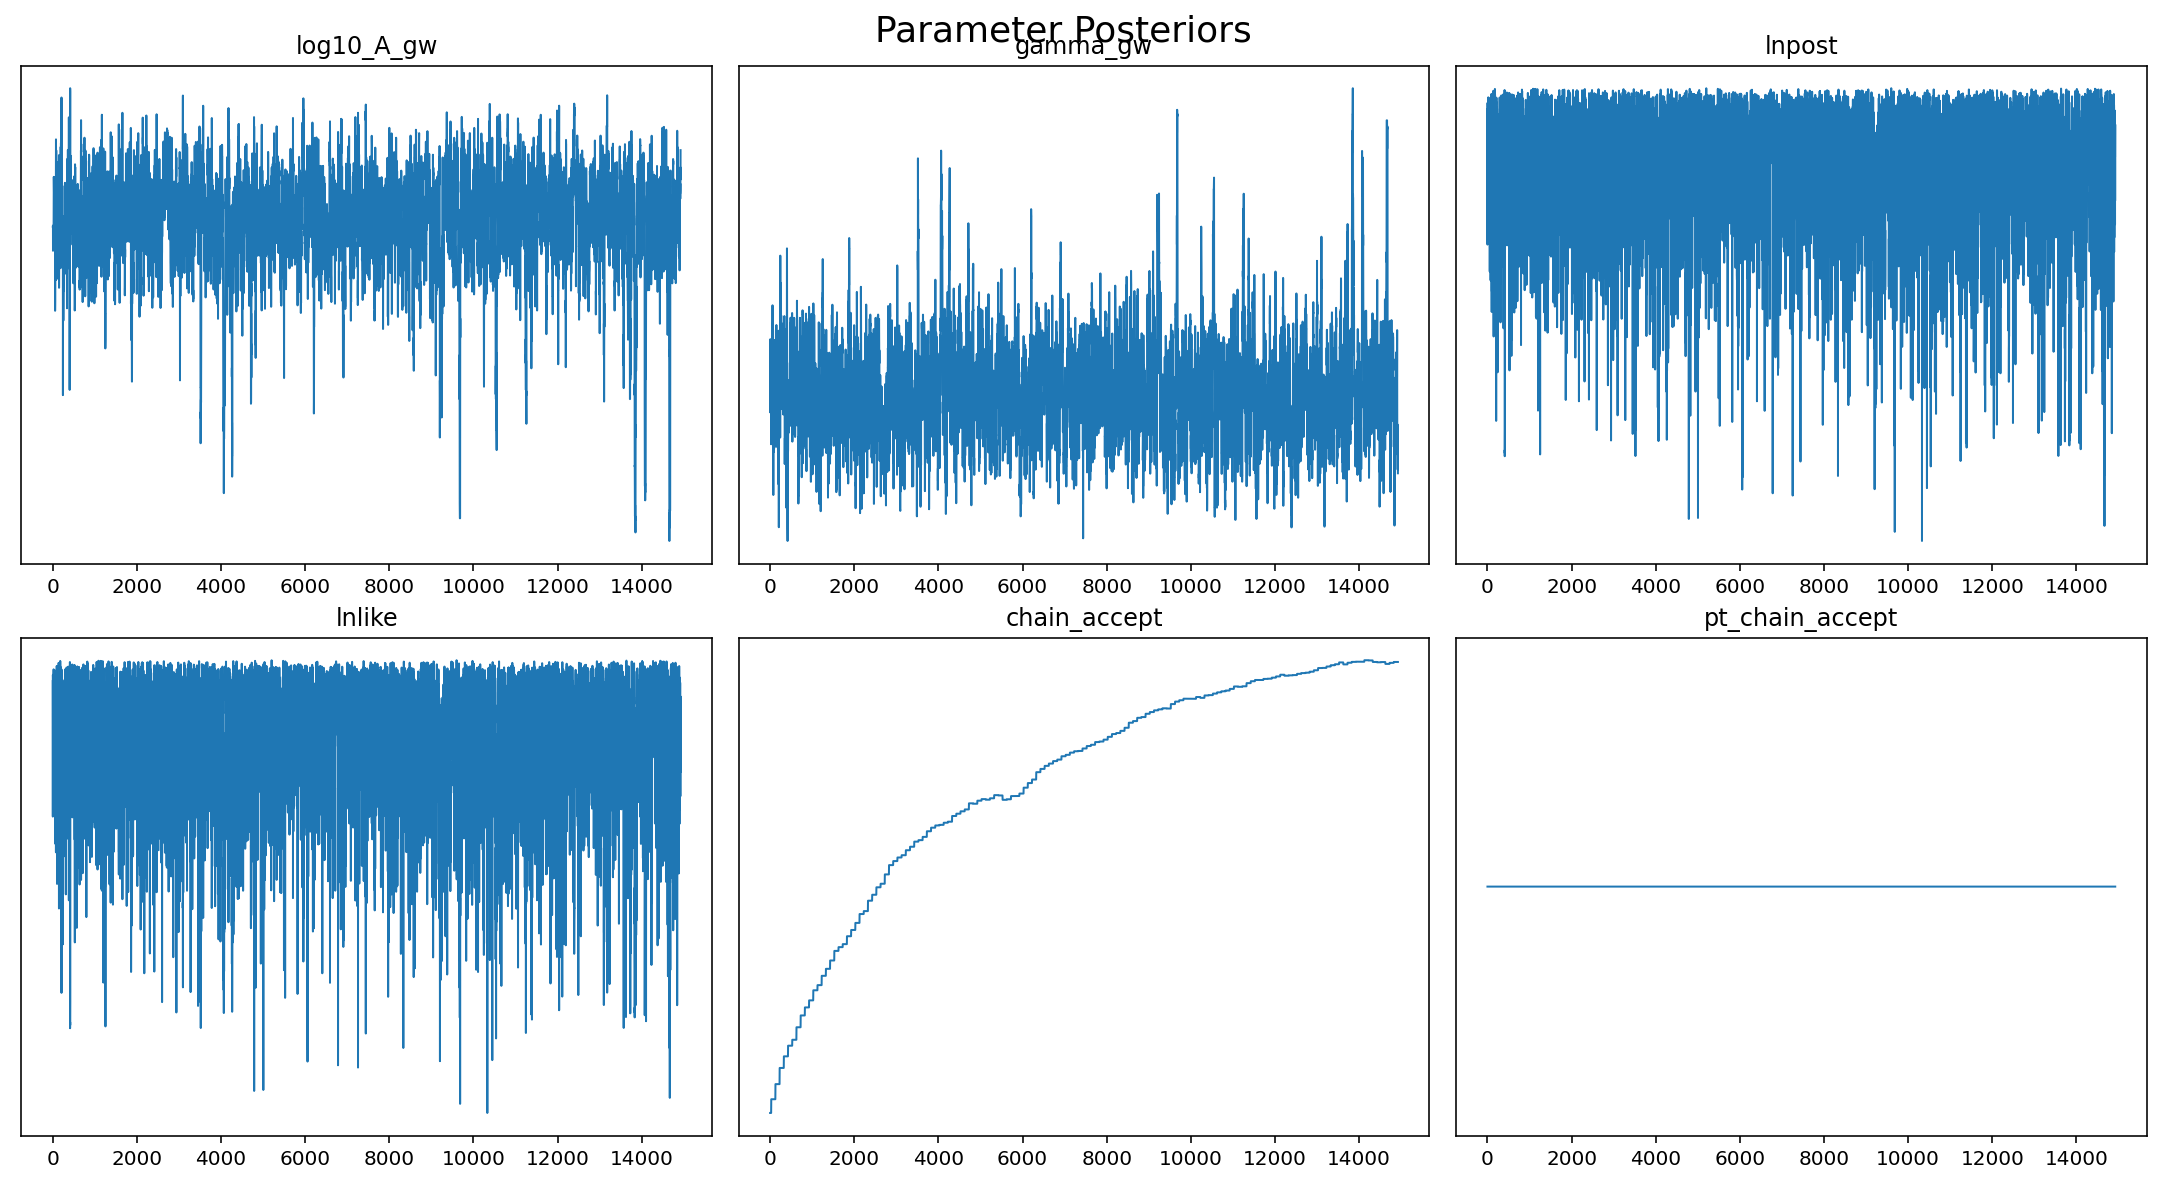

In [11]:
dg.plot_chains(pl10f, hist=False)

let's also numerical check if it has converged. If all points are below the dashed line, we are good to go (but to be safe, you should also check if all parameters have small autocorrelations lengths too by using `emcee.autocorr`

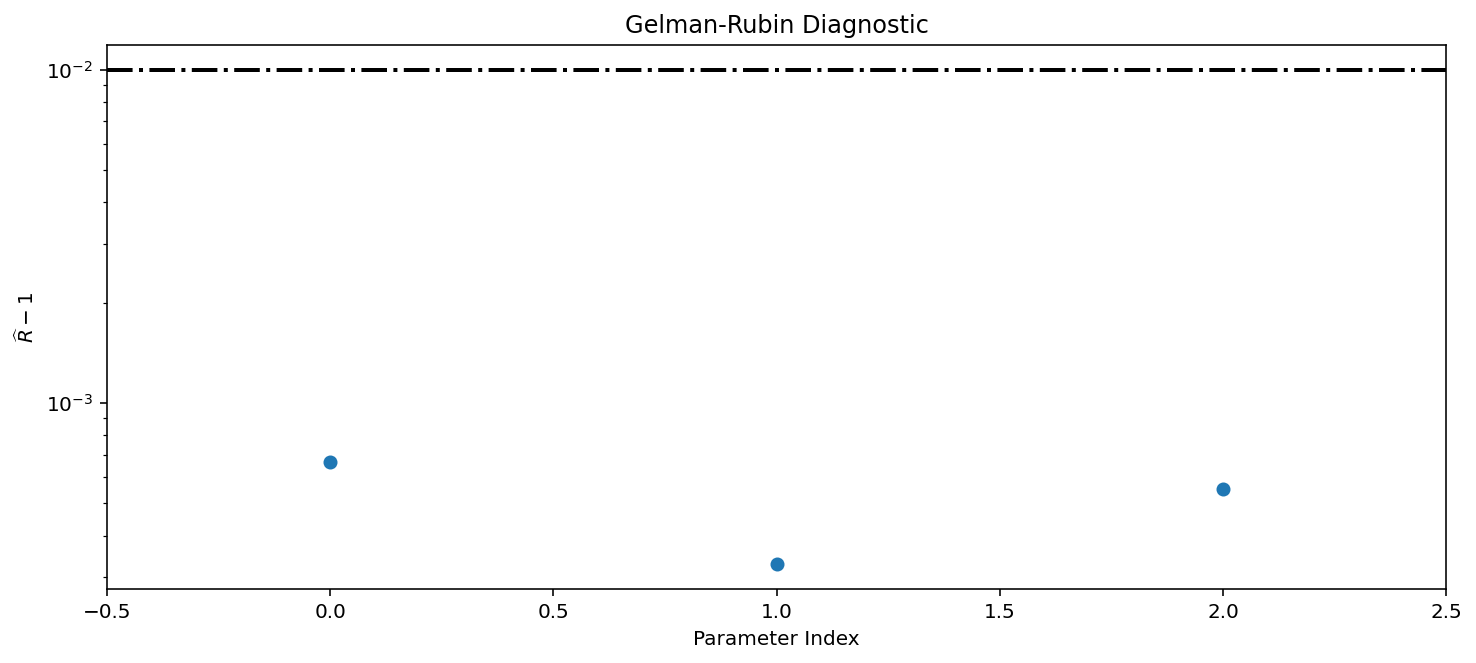

In [12]:
dg.plot_grubin(pl10f)

Let's make a corner plot!

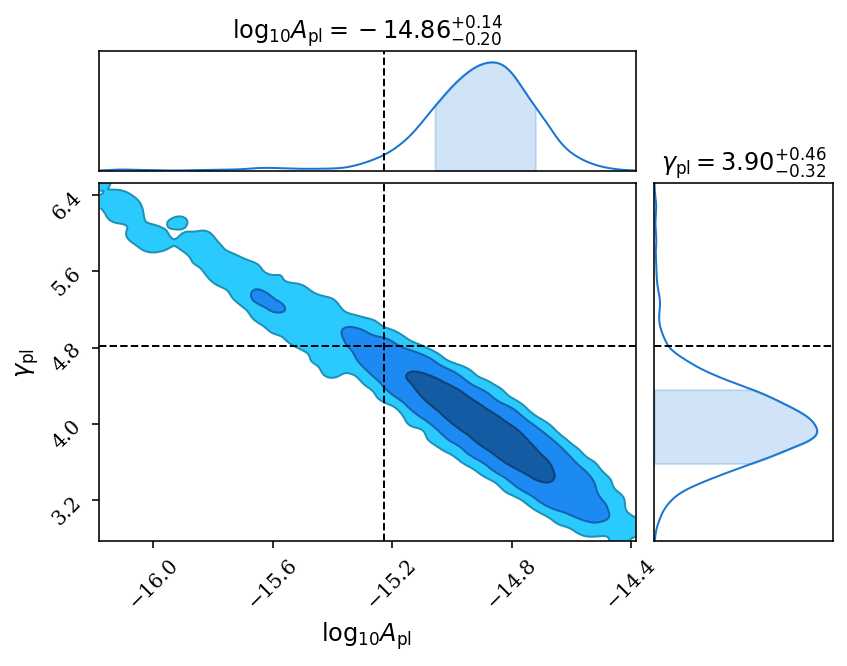

In [13]:
tex = [r'$\log_{10}A_\mathrm{pl}$', r'$\gamma_\mathrm{pl}$']

c = ChainConsumer()
c.add_chain(pl10f(pl10f.params[:2]),
            parameters=tex)
c.configure(usetex=False, summary=True, sigmas=[1,2,3])
c.plotter.plot(figsize=(6,4), truth=[log10A_inj, gamma_inj]);

The 'truth' lines are the injected powerlaw parameters. Our analysis captures the injection well within the 95% credible region. This is good, but we should compare it to a typical uncorrelated powerlaw analysis

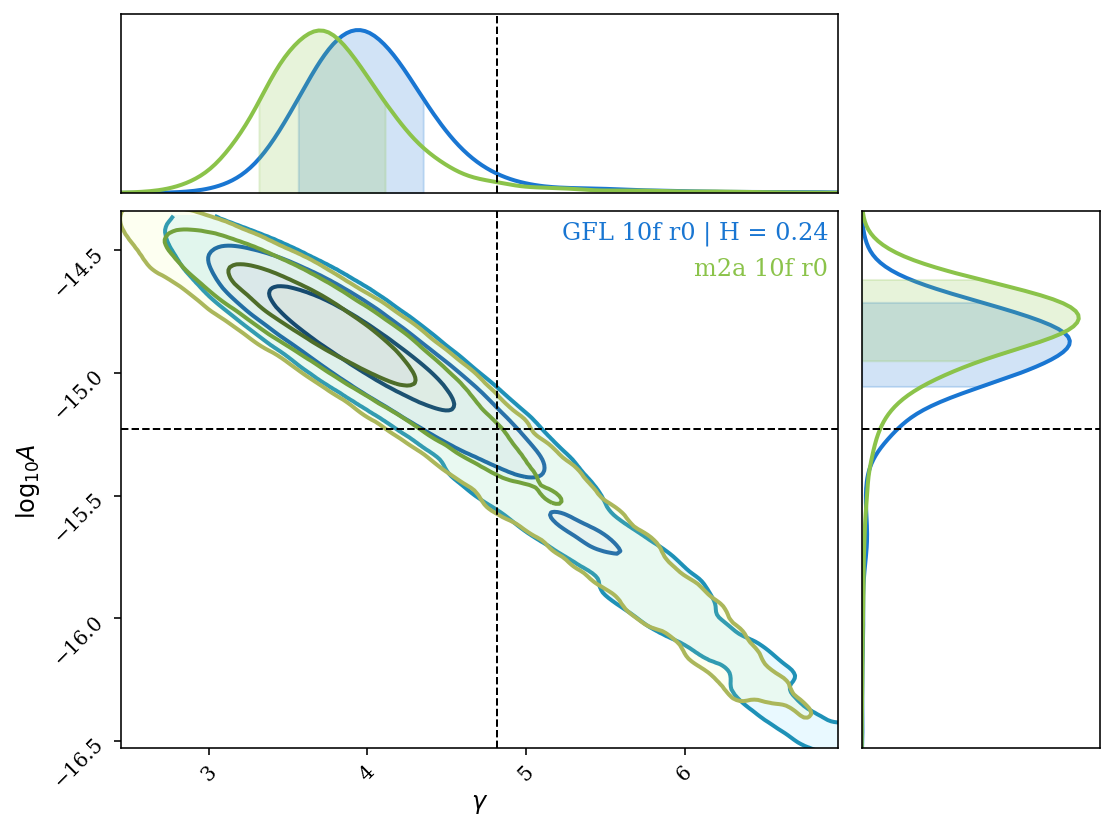

Let's take the maximum likelihood parameters from this run and plot it on the free spectrum. We'll compare it to the injected powerlaw

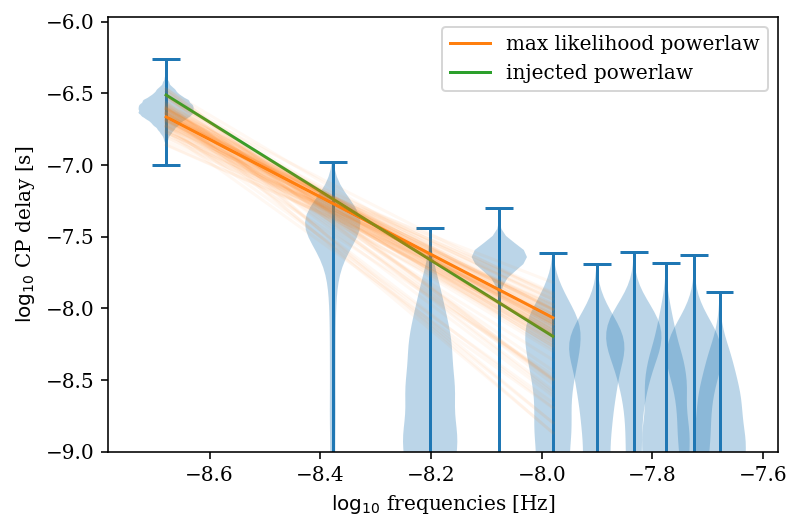

In [32]:
idx = np.where(pl10f('lnpost').max()==pl10f('lnpost'))[0][0]
log10_A, gamma = pl5f.chain[pl5f.burn:][idx][:2]
pl = 0.5*np.log10(models.powerlaw(pl5f.rn_freqs[:5], log10_A=log10_A,
                                  gamma=gamma))

idx = np.random.randint(0, pl5f.chain[pl5f.burn:].shape[0],
                        100)
log10_A, gamma = pl5f.chain[pl5f.burn:][idx][:,:2].T
plspread = 0.5*np.log10(models.powerlaw(pl5f.rn_freqs[:5][None,:].T,
                                        log10_A=log10_A,
                                        gamma=gamma))

pl_inj = 0.5*np.log10(models.powerlaw(pl5f.rn_freqs[:5], log10_A=log10A_inj,
                                      gamma=gamma_inj))

plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-5])),
               positions=np.log10(freespec.rn_freqs),
               widths=0.1)
plt.plot(np.log10(pl5f.rn_freqs[:5]), pl, label='max likelihood powerlaw')
plt.plot(np.log10(pl5f.rn_freqs[:5]), pl_inj, label='injected powerlaw')
plt.plot(np.log10(pl5f.rn_freqs[:5]), plspread, color='C1',
         alpha=0.05)
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')
plt.ylim(-9)
plt.legend();

##### What if I want to try a different model?

Then just change the model function... All models supported right now are found in `ceffyl.models`. *These are equivalent to the functions in `enterprise.gp_priors`, except they're faster as the don't require repeated frequencies and they are vectorised. Note that the functions in `enterprise.gp_priors` will not work with `ceffyl`.*

What about a broken powerlaw with fixed $\gamma$?

In [15]:
# first we need to define some priors on log10_A and the break frequency, log10_fb
# it's just like defining priors in a standard enterprise run!
log10A = parameter.Uniform(-18, -12)('log10_A')
log10_fb = parameter.Uniform(-9, -7)('log10_fb')

# then we define gamma as a constant float
const_params = dict(gamma=gamma_inj)

# then we choose our model
psd = models.broken_powerlaw

In [16]:
# and the create our signal!
gw = Ceffyl.signal(N_freqs=10, psd=psd,
                   params=[log10A, log10_fb],
                   const_params=const_params)

In [17]:
pta2 = Ceffyl.ceffyl(datadir='../data/sim0/fs_densities/')
pta2.add_signals([gw])

In [18]:
# and finally, we setup the sampler!
sampler = Sampler.setup_sampler(pta2,
                                outdir='../data/sim0/refits/10fbpl/',
                                logL=pta2.ln_likelihood,
                                logp=pta2.ln_prior, resume=False)
x0 = pta2.initial_samples()  # get initial sample
sampler.sample(x0, int(200000))

Adding GWB uniform distribution draws...

Finished 5.00 percent in 3.001187 s Acceptance rate = 0.327911Adding DE jump with weight 20
Finished 99.50 percent in 57.986946 s Acceptance rate = 0.414588
Run Complete


##### read the chain and run convergence tests...

In [19]:
c0 = co.Core('../data/sim0/refits/10fbpl/')
c0.set_rn_freqs(Tspan=1/freespec.rn_freqs[0], nfreqs=10)
c0.save('../data/sim0/refits/10fbpl/chain.core')
bpl10f = co.Core(corepath='../data/sim0/refits/10fbpl/chain.core')

INFO:la_forge.core:Appending ['lnpost','lnlike','chain_accept','pt_chain_accept'] to end of params list.


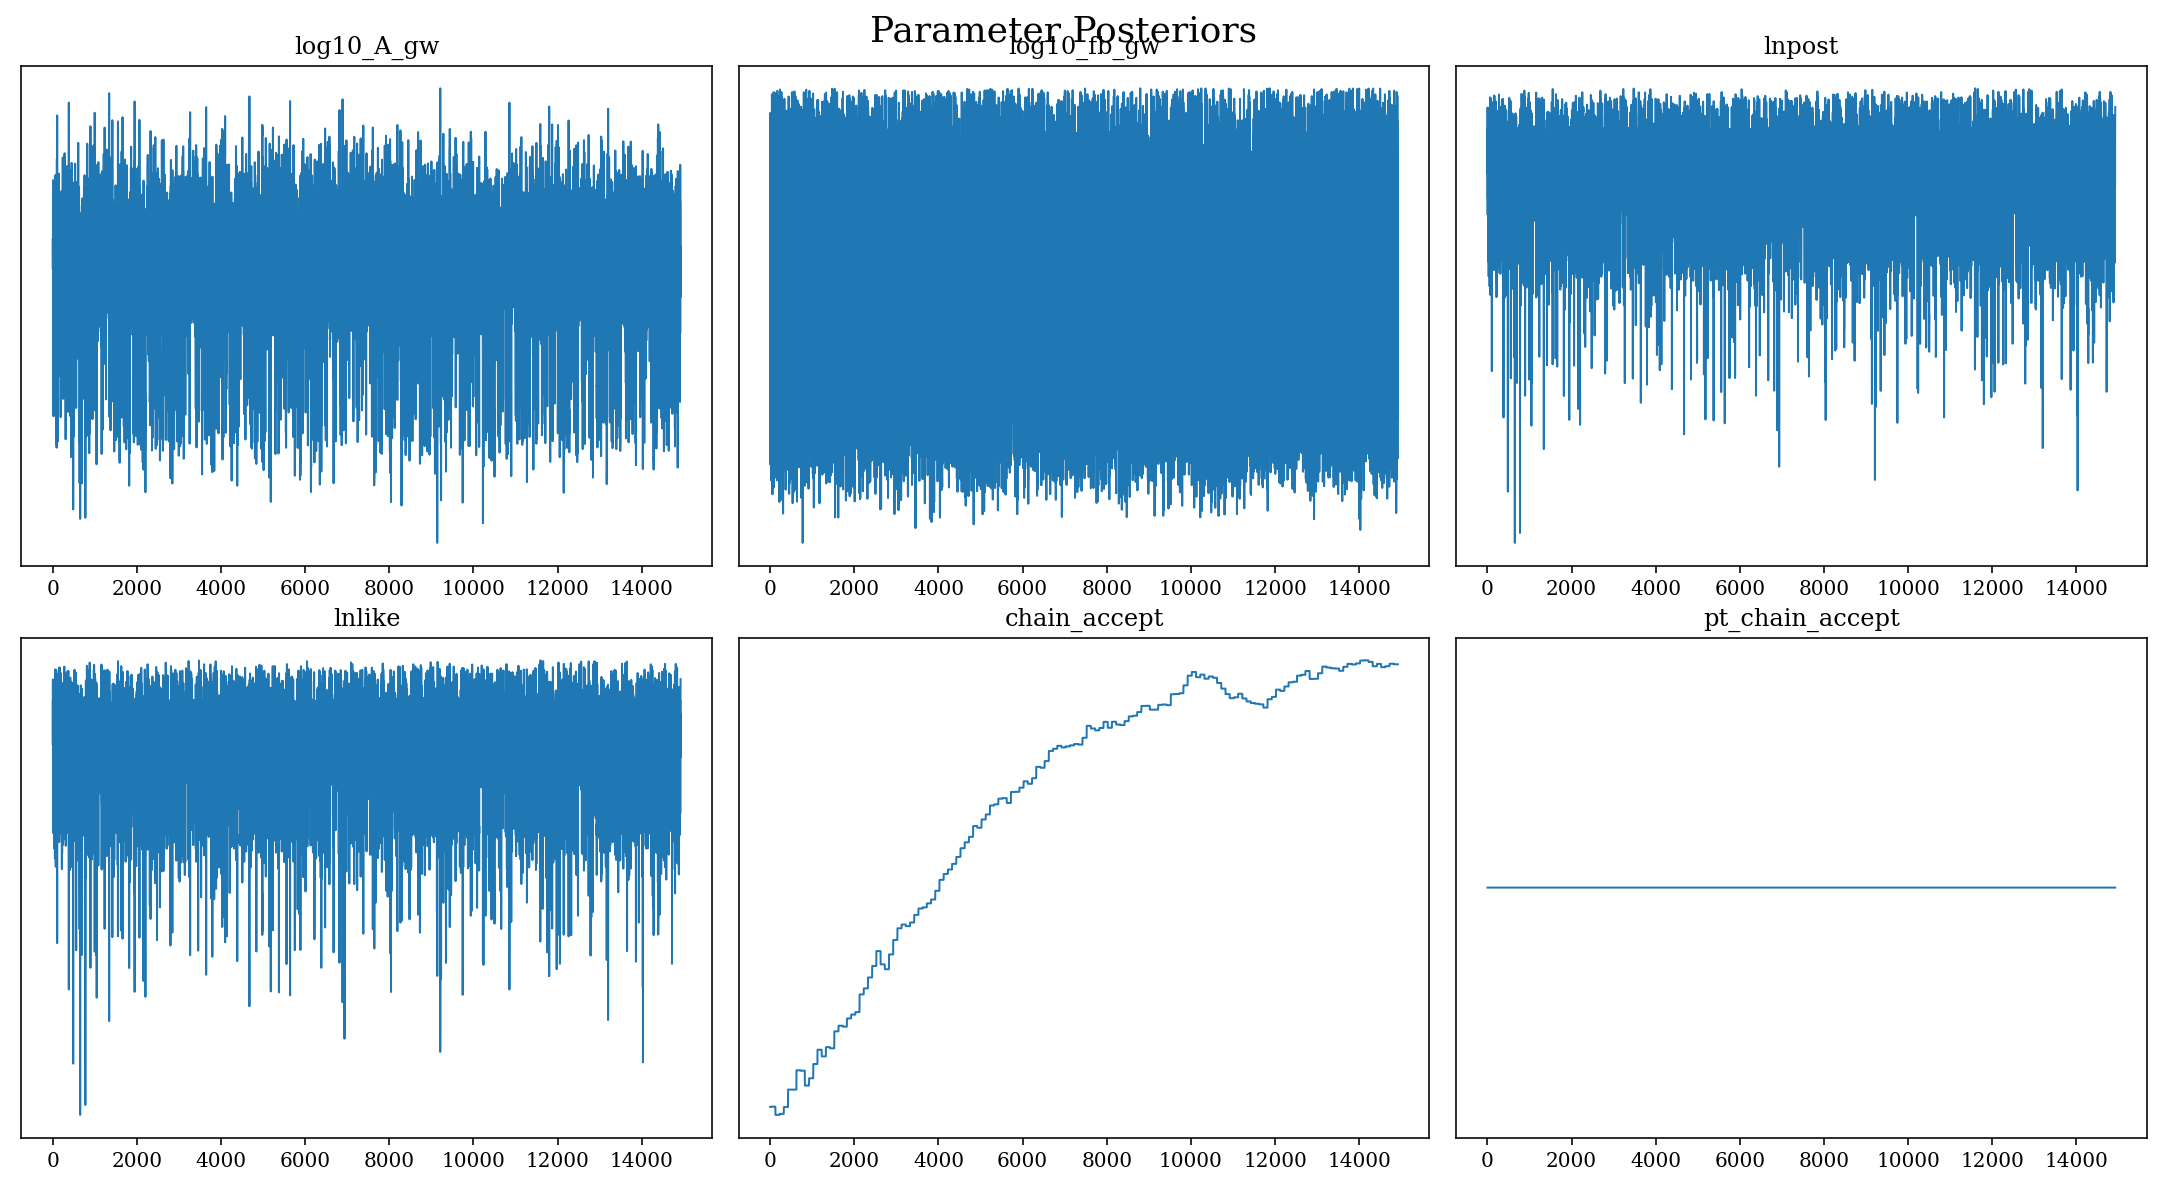

In [20]:
# checking the traceplot
dg.plot_chains(bpl10f, hist=False)

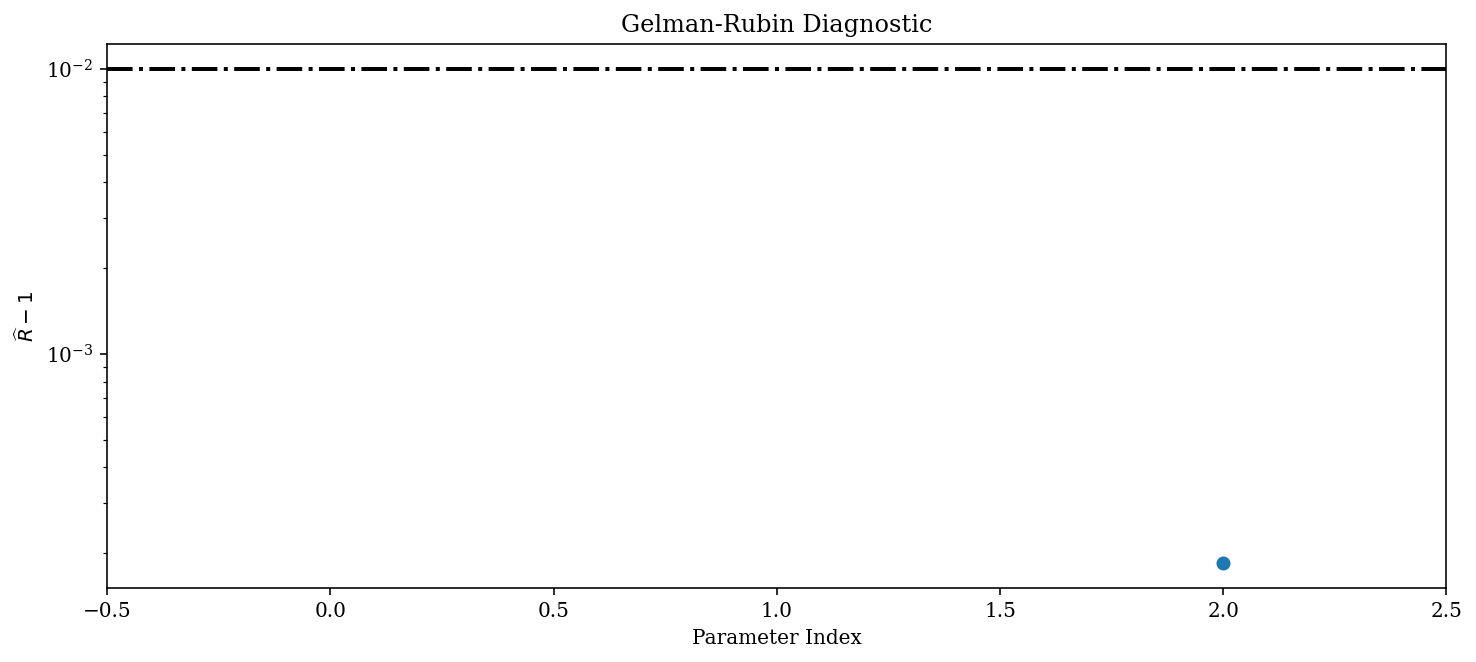

In [21]:
dg.plot_grubin(bpl10f)

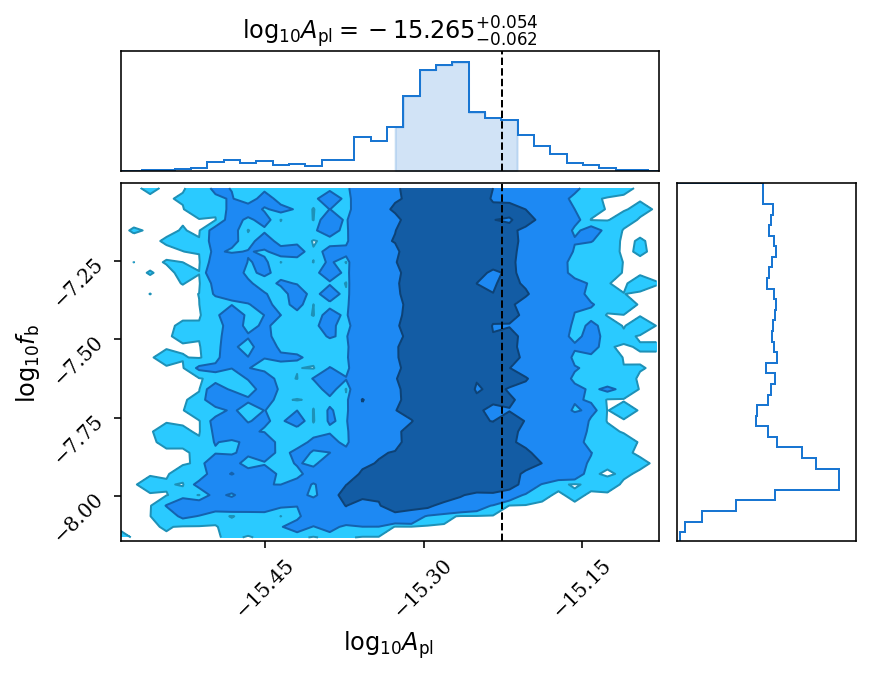

In [22]:
# let's make a corner plot!
tex = [r'$\log_{10}A_\mathrm{pl}$', r'$\log_{10}f_\mathrm{b}$']

c = ChainConsumer()
c.add_chain(bpl10f(bpl10f.params[:2]),
            parameters=tex)
c.configure(usetex=False, summary=True, sigmas=[1,2,3],
            smooth=False)
c.plotter.plot(figsize=(6,4), truth=[log10A_inj]);

this run really captured the injected amplitude well!

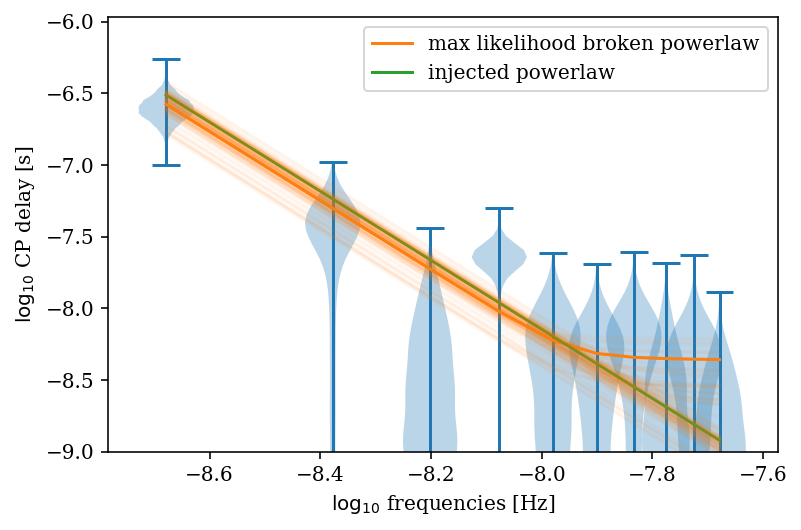

In [36]:
idx = np.where(bpl10f('lnpost').max()==bpl10f('lnpost'))[0][0]
log10_A, log10_fb = bpl10f.chain[bpl10f.burn:][idx][:2]

bpl = 0.5*np.log10(models.broken_powerlaw(bpl10f.rn_freqs, log10_A=log10_A,
                                          gamma=gamma_inj, log10_fb=log10_fb))

idx = np.random.randint(0, bpl10f.chain[bpl10f.burn:].shape[0],
                        100)
log10_A, log10_fb = bpl10f.chain[bpl10f.burn:][idx][:,:2].T
plspread = 0.5*np.log10(models.broken_powerlaw(bpl10f.rn_freqs[None,:].T,
                                               log10_A=log10_A,
                                               gamma=gamma_inj,
                                               log10_fb=log10_fb))

pl_inj = 0.5*np.log10(models.powerlaw(bpl10f.rn_freqs, log10_A=log10A_inj,
                                      gamma=gamma_inj))

plt.violinplot(pd.DataFrame(freespec(freespec.params[-15:-5])),
               positions=np.log10(freespec.rn_freqs),
               widths=0.1)
plt.plot(np.log10(bpl10f.rn_freqs), bpl, label='max likelihood broken powerlaw')
plt.plot(np.log10(bpl10f.rn_freqs), pl_inj, label='injected powerlaw')
plt.plot(np.log10(bpl10f.rn_freqs), plspread, color='C1',
         alpha=0.05)
plt.xlabel('$\log_{10}$ frequencies [Hz]')
plt.ylabel(r'$\log_{10}$ CP delay [s]')
plt.ylim(-9)
plt.legend();

##### ultranest

Model analysis with nested sampling is easy! Take your ceffyl object and easily put it your favourite nested sampler

In [26]:
sampler1 = ultranest.ReactiveNestedSampler(pta.param_names,
                                          loglike=pta.ln_likelihood,
                                          transform=pta.transform_histogram,
                                          resume='overwrite',
                                          log_dir='../data/sim0/refits/5fpl_nested/')

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=../data/sim0/refits/5fpl_nested/, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [27]:
result1 = sampler1.run()
sampler1.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau

DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.918700e+02,

DEBUG:ultranest:iteration=113, ncalls=402, regioncalls=80, ndraw=40, logz=-193.13, remainder_fraction=100.0000%, Lmin=-191.87, Lmax=-19.40


DEBUG:ultranest:iteration=120, ncalls=413, regioncalls=520, ndraw=40, logz=-164.90, remainder_fraction=100.0000%, Lmin=-159.61, Lmax=-17.64


DEBUG:ultranest:iteration=138, ncalls=436, regioncalls=1440, ndraw=40, logz=-129.26, remainder_fraction=100.0000%, Lmin=-122.70, Lmax=-17.64


DEBUG:ultranest:iteration=160, ncalls=465, regioncalls=2600, ndraw=40, logz=-93.04, remainder_fraction=100.0000%, Lmin=-89.06, Lmax=-17.64


DEBUG:ultranest:iteration=178, ncalls=494, regioncalls=3760, ndraw=40, logz=-91.93, remainder_fraction=100.0000%, Lmin=-89.00, Lmax=-17.64


DEBUG:ultranest:iteration=200, ncalls=523, regioncalls=4920, ndraw=40, logz=-91.34, remainder_fraction=100.0000%, Lmin=-88.93, Lmax=-17.52


DEBUG:ultranest:iteration=240, ncalls=591, regioncalls=7640, ndraw=40, logz=-90.75, remainder_fraction=100.0000%, Lmin=-88.82, Lmax=-16.86


DEBUG:ultranest:iteration=243, ncalls=595, regioncalls=7800, ndraw=40, logz=-90.71, remainder_fraction=100.0000%, Lmin=-88.81, Lmax=-16.86


DEBUG:ultranest:iteration=280, ncalls=645, regioncalls=9800, ndraw=40, logz=-90.37, remainder_fraction=100.0000%, Lmin=-64.61, Lmax=-16.86


DEBUG:ultranest:iteration=320, ncalls=708, regioncalls=12360, ndraw=40, logz=-64.07, remainder_fraction=100.0000%, Lmin=-60.44, Lmax=-16.86


DEBUG:ultranest:iteration=360, ncalls=804, regioncalls=16200, ndraw=40, logz=-62.77, remainder_fraction=100.0000%, Lmin=-59.69, Lmax=-16.74


DEBUG:ultranest:iteration=373, ncalls=820, regioncalls=16840, ndraw=40, logz=-62.50, remainder_fraction=100.0000%, Lmin=-59.53, Lmax=-16.74


DEBUG:ultranest:iteration=400, ncalls=884, regioncalls=19440, ndraw=40, logz=-62.06, remainder_fraction=100.0000%, Lmin=-59.36, Lmax=-16.74


DEBUG:ultranest:iteration=438, ncalls=995, regioncalls=23880, ndraw=40, logz=-61.63, remainder_fraction=100.0000%, Lmin=-59.16, Lmax=-16.74


DEBUG:ultranest:iteration=440, ncalls=1000, regioncalls=24080, ndraw=40, logz=-61.61, remainder_fraction=100.0000%, Lmin=-59.14, Lmax=-16.74
DEBUG:ultranest:Plateau detected at L=-5.902714e+01, not replacing live point.


DEBUG:ultranest:iteration=453, ncalls=1039, regioncalls=25640, ndraw=40, logz=-61.49, remainder_fraction=100.0000%, Lmin=-59.03, Lmax=-16.74


DEBUG:ultranest:iteration=480, ncalls=1137, regioncalls=29560, ndraw=40, logz=-61.27, remainder_fraction=100.0000%, Lmin=-58.88, Lmax=-16.74


DEBUG:ultranest:iteration=517, ncalls=1269, regioncalls=34880, ndraw=40, logz=-61.02, remainder_fraction=100.0000%, Lmin=-58.72, Lmax=-16.74


DEBUG:ultranest:iteration=520, ncalls=1282, regioncalls=35400, ndraw=40, logz=-61.00, remainder_fraction=100.0000%, Lmin=-58.71, Lmax=-16.74


DEBUG:ultranest:iteration=560, ncalls=1401, regioncalls=40160, ndraw=40, logz=-60.78, remainder_fraction=100.0000%, Lmin=-58.44, Lmax=-16.74
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3]), array([253,  32,   1]))


DEBUG:ultranest:iteration=587, ncalls=1503, regioncalls=44240, ndraw=40, logz=-60.64, remainder_fraction=100.0000%, Lmin=-58.26, Lmax=-16.70


DEBUG:ultranest:iteration=600, ncalls=1568, regioncalls=46840, ndraw=40, logz=-60.57, remainder_fraction=100.0000%, Lmin=-58.18, Lmax=-16.70
DEBUG:ultranest:Plateau detected at L=-5.785116e+01, not replacing live point.


DEBUG:ultranest:iteration=634, ncalls=1743, regioncalls=53840, ndraw=40, logz=-60.40, remainder_fraction=100.0000%, Lmin=-57.85, Lmax=-16.70


DEBUG:ultranest:iteration=640, ncalls=1804, regioncalls=56280, ndraw=40, logz=-60.37, remainder_fraction=100.0000%, Lmin=-57.81, Lmax=-16.70


DEBUG:ultranest:iteration=671, ncalls=1996, regioncalls=63960, ndraw=40, logz=-60.21, remainder_fraction=100.0000%, Lmin=-57.49, Lmax=-16.70


DEBUG:ultranest:iteration=680, ncalls=2030, regioncalls=65320, ndraw=40, logz=-60.16, remainder_fraction=100.0000%, Lmin=-57.44, Lmax=-16.70


DEBUG:ultranest:iteration=698, ncalls=2094, regioncalls=67880, ndraw=40, logz=-60.05, remainder_fraction=100.0000%, Lmin=-56.94, Lmax=-16.70


DEBUG:ultranest:iteration=720, ncalls=2132, regioncalls=69400, ndraw=40, logz=-59.83, remainder_fraction=100.0000%, Lmin=-56.19, Lmax=-16.68


DEBUG:ultranest:iteration=760, ncalls=2212, regioncalls=72600, ndraw=40, logz=-59.14, remainder_fraction=100.0000%, Lmin=-54.77, Lmax=-16.68


DEBUG:ultranest:iteration=795, ncalls=2269, regioncalls=74880, ndraw=40, logz=-58.36, remainder_fraction=100.0000%, Lmin=-53.83, Lmax=-16.68


DEBUG:ultranest:iteration=800, ncalls=2283, regioncalls=75440, ndraw=40, logz=-58.25, remainder_fraction=100.0000%, Lmin=-53.63, Lmax=-16.68


DEBUG:ultranest:iteration=836, ncalls=2361, regioncalls=78640, ndraw=40, logz=-57.00, remainder_fraction=100.0000%, Lmin=-50.77, Lmax=-16.62


DEBUG:ultranest:iteration=840, ncalls=2367, regioncalls=78880, ndraw=40, logz=-56.53, remainder_fraction=100.0000%, Lmin=-49.84, Lmax=-16.62


DEBUG:ultranest:iteration=880, ncalls=2443, regioncalls=81920, ndraw=40, logz=-33.85, remainder_fraction=99.9992%, Lmin=-27.76, Lmax=-16.62


DEBUG:ultranest:iteration=890, ncalls=2472, regioncalls=83080, ndraw=40, logz=-33.09, remainder_fraction=99.9983%, Lmin=-26.98, Lmax=-16.62


DEBUG:ultranest:iteration=920, ncalls=2538, regioncalls=85760, ndraw=40, logz=-30.88, remainder_fraction=99.9835%, Lmin=-24.85, Lmax=-16.62


DEBUG:ultranest:iteration=954, ncalls=2596, regioncalls=88120, ndraw=40, logz=-29.34, remainder_fraction=99.9183%, Lmin=-23.81, Lmax=-16.62


DEBUG:ultranest:iteration=960, ncalls=2604, regioncalls=88440, ndraw=40, logz=-29.15, remainder_fraction=99.9025%, Lmin=-23.70, Lmax=-16.62


DEBUG:ultranest:iteration=1000, ncalls=2674, regioncalls=91360, ndraw=40, logz=-28.03, remainder_fraction=99.6953%, Lmin=-22.59, Lmax=-16.62


DEBUG:ultranest:iteration=1036, ncalls=2733, regioncalls=93720, ndraw=40, logz=-27.15, remainder_fraction=99.2396%, Lmin=-21.81, Lmax=-16.62


DEBUG:ultranest:iteration=1040, ncalls=2739, regioncalls=93960, ndraw=40, logz=-27.07, remainder_fraction=99.1705%, Lmin=-21.74, Lmax=-16.62


DEBUG:ultranest:iteration=1080, ncalls=2823, regioncalls=97320, ndraw=40, logz=-26.34, remainder_fraction=98.2813%, Lmin=-21.05, Lmax=-16.62


DEBUG:ultranest:iteration=1112, ncalls=2888, regioncalls=99920, ndraw=40, logz=-25.87, remainder_fraction=97.2451%, Lmin=-20.71, Lmax=-16.62


DEBUG:ultranest:iteration=1120, ncalls=2906, regioncalls=100640, ndraw=40, logz=-25.77, remainder_fraction=96.9177%, Lmin=-20.66, Lmax=-16.62


DEBUG:ultranest:iteration=1152, ncalls=2989, regioncalls=103960, ndraw=40, logz=-25.40, remainder_fraction=95.4477%, Lmin=-20.30, Lmax=-16.62


DEBUG:ultranest:iteration=1160, ncalls=3009, regioncalls=104760, ndraw=40, logz=-25.32, remainder_fraction=95.2058%, Lmin=-20.26, Lmax=-16.62


DEBUG:ultranest:iteration=1200, ncalls=3108, regioncalls=108720, ndraw=40, logz=-24.94, remainder_fraction=93.0819%, Lmin=-19.92, Lmax=-16.62
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2]), array([284,   1]))


DEBUG:ultranest:iteration=1228, ncalls=3173, regioncalls=111320, ndraw=40, logz=-24.72, remainder_fraction=91.3584%, Lmin=-19.69, Lmax=-16.62


DEBUG:ultranest:iteration=1240, ncalls=3203, regioncalls=112520, ndraw=40, logz=-24.63, remainder_fraction=90.4511%, Lmin=-19.58, Lmax=-16.62


DEBUG:ultranest:iteration=1274, ncalls=3304, regioncalls=116560, ndraw=40, logz=-24.38, remainder_fraction=87.7380%, Lmin=-19.34, Lmax=-16.62


DEBUG:ultranest:iteration=1280, ncalls=3329, regioncalls=117600, ndraw=40, logz=-24.35, remainder_fraction=87.2177%, Lmin=-19.33, Lmax=-16.62


DEBUG:ultranest:iteration=1319, ncalls=3455, regioncalls=122640, ndraw=40, logz=-24.11, remainder_fraction=83.9662%, Lmin=-19.08, Lmax=-16.62


DEBUG:ultranest:iteration=1320, ncalls=3457, regioncalls=122720, ndraw=40, logz=-24.11, remainder_fraction=83.8426%, Lmin=-19.08, Lmax=-16.62


DEBUG:ultranest:iteration=1338, ncalls=3521, regioncalls=125400, ndraw=40, logz=-24.01, remainder_fraction=82.2529%, Lmin=-18.95, Lmax=-16.62


DEBUG:ultranest:iteration=1360, ncalls=3569, regioncalls=127400, ndraw=40, logz=-23.89, remainder_fraction=80.1286%, Lmin=-18.87, Lmax=-16.62


DEBUG:ultranest:iteration=1398, ncalls=3652, regioncalls=130720, ndraw=40, logz=-23.72, remainder_fraction=76.4677%, Lmin=-18.65, Lmax=-16.61


DEBUG:ultranest:iteration=1400, ncalls=3658, regioncalls=130960, ndraw=40, logz=-23.71, remainder_fraction=76.2085%, Lmin=-18.64, Lmax=-16.61


DEBUG:ultranest:iteration=1427, ncalls=3734, regioncalls=134000, ndraw=40, logz=-23.59, remainder_fraction=73.4197%, Lmin=-18.51, Lmax=-16.61


DEBUG:ultranest:iteration=1440, ncalls=3769, regioncalls=135400, ndraw=40, logz=-23.54, remainder_fraction=72.1854%, Lmin=-18.46, Lmax=-16.54


DEBUG:ultranest:iteration=1466, ncalls=3853, regioncalls=138800, ndraw=40, logz=-23.44, remainder_fraction=69.4364%, Lmin=-18.37, Lmax=-16.54


DEBUG:ultranest:iteration=1480, ncalls=3872, regioncalls=139560, ndraw=40, logz=-23.39, remainder_fraction=68.0767%, Lmin=-18.27, Lmax=-16.54


DEBUG:ultranest:iteration=1520, ncalls=3935, regioncalls=142080, ndraw=40, logz=-23.26, remainder_fraction=63.8852%, Lmin=-18.16, Lmax=-16.54


DEBUG:ultranest:iteration=1530, ncalls=3949, regioncalls=142680, ndraw=40, logz=-23.23, remainder_fraction=62.7991%, Lmin=-18.13, Lmax=-16.54


DEBUG:ultranest:iteration=1560, ncalls=3985, regioncalls=144120, ndraw=40, logz=-23.15, remainder_fraction=59.3508%, Lmin=-18.03, Lmax=-16.54


DEBUG:ultranest:iteration=1598, ncalls=4044, regioncalls=146480, ndraw=40, logz=-23.05, remainder_fraction=55.1929%, Lmin=-17.89, Lmax=-16.54


DEBUG:ultranest:iteration=1600, ncalls=4047, regioncalls=146600, ndraw=40, logz=-23.05, remainder_fraction=55.0113%, Lmin=-17.88, Lmax=-16.54
DEBUG:ultranest:Plateau detected at L=-1.776063e+01, not replacing live point.


DEBUG:ultranest:iteration=1641, ncalls=4112, regioncalls=149320, ndraw=40, logz=-22.96, remainder_fraction=50.6800%, Lmin=-17.76, Lmax=-16.54


DEBUG:ultranest:iteration=1674, ncalls=4164, regioncalls=151440, ndraw=40, logz=-22.89, remainder_fraction=47.0035%, Lmin=-17.68, Lmax=-16.54


DEBUG:ultranest:iteration=1680, ncalls=4171, regioncalls=151720, ndraw=40, logz=-22.88, remainder_fraction=46.3382%, Lmin=-17.66, Lmax=-16.54


DEBUG:ultranest:iteration=1715, ncalls=4227, regioncalls=154000, ndraw=40, logz=-22.81, remainder_fraction=42.8871%, Lmin=-17.58, Lmax=-16.54


DEBUG:ultranest:iteration=1720, ncalls=4239, regioncalls=154480, ndraw=40, logz=-22.80, remainder_fraction=42.3892%, Lmin=-17.57, Lmax=-16.54


DEBUG:ultranest:iteration=1760, ncalls=4311, regioncalls=157400, ndraw=40, logz=-22.74, remainder_fraction=38.3952%, Lmin=-17.48, Lmax=-16.54


DEBUG:ultranest:iteration=1769, ncalls=4324, regioncalls=157960, ndraw=40, logz=-22.73, remainder_fraction=37.5325%, Lmin=-17.46, Lmax=-16.54


DEBUG:ultranest:iteration=1800, ncalls=4374, regioncalls=159960, ndraw=40, logz=-22.68, remainder_fraction=34.6514%, Lmin=-17.41, Lmax=-16.54


DEBUG:ultranest:iteration=1834, ncalls=4433, regioncalls=162360, ndraw=40, logz=-22.64, remainder_fraction=31.8012%, Lmin=-17.36, Lmax=-16.54


DEBUG:ultranest:iteration=1840, ncalls=4445, regioncalls=162920, ndraw=40, logz=-22.63, remainder_fraction=31.3154%, Lmin=-17.35, Lmax=-16.54


DEBUG:ultranest:iteration=1880, ncalls=4498, regioncalls=165040, ndraw=40, logz=-22.59, remainder_fraction=28.3367%, Lmin=-17.29, Lmax=-16.54


DEBUG:ultranest:iteration=1920, ncalls=4559, regioncalls=167480, ndraw=40, logz=-22.55, remainder_fraction=25.4343%, Lmin=-17.24, Lmax=-16.54


DEBUG:ultranest:iteration=1960, ncalls=4623, regioncalls=170040, ndraw=40, logz=-22.52, remainder_fraction=22.7202%, Lmin=-17.18, Lmax=-16.54


DEBUG:ultranest:iteration=1961, ncalls=4625, regioncalls=170160, ndraw=40, logz=-22.51, remainder_fraction=22.6449%, Lmin=-17.18, Lmax=-16.54


DEBUG:ultranest:iteration=1998, ncalls=4686, regioncalls=172600, ndraw=40, logz=-22.49, remainder_fraction=20.5929%, Lmin=-17.13, Lmax=-16.54


DEBUG:ultranest:iteration=2000, ncalls=4691, regioncalls=172800, ndraw=40, logz=-22.49, remainder_fraction=20.5031%, Lmin=-17.13, Lmax=-16.54


DEBUG:ultranest:iteration=2036, ncalls=4759, regioncalls=175520, ndraw=40, logz=-22.46, remainder_fraction=18.5240%, Lmin=-17.09, Lmax=-16.54


DEBUG:ultranest:iteration=2040, ncalls=4766, regioncalls=175840, ndraw=40, logz=-22.46, remainder_fraction=18.3327%, Lmin=-17.09, Lmax=-16.54


DEBUG:ultranest:iteration=2080, ncalls=4840, regioncalls=178920, ndraw=40, logz=-22.43, remainder_fraction=16.3174%, Lmin=-17.07, Lmax=-16.54
DEBUG:ultranest:clustering found some stray points [need_accept=False] (array([1, 2, 3]), array([273,  10,   1]))


DEBUG:ultranest:iteration=2119, ncalls=4902, regioncalls=181440, ndraw=40, logz=-22.41, remainder_fraction=14.5956%, Lmin=-17.03, Lmax=-16.54


DEBUG:ultranest:iteration=2120, ncalls=4903, regioncalls=181480, ndraw=40, logz=-22.41, remainder_fraction=14.5667%, Lmin=-17.03, Lmax=-16.54


DEBUG:ultranest:iteration=2153, ncalls=4973, regioncalls=184480, ndraw=40, logz=-22.40, remainder_fraction=13.2340%, Lmin=-16.98, Lmax=-16.54


DEBUG:ultranest:iteration=2160, ncalls=4988, regioncalls=185080, ndraw=40, logz=-22.40, remainder_fraction=12.9503%, Lmin=-16.98, Lmax=-16.54


DEBUG:ultranest:iteration=2200, ncalls=5053, regioncalls=187680, ndraw=40, logz=-22.38, remainder_fraction=11.5047%, Lmin=-16.93, Lmax=-16.54


DEBUG:ultranest:iteration=2217, ncalls=5084, regioncalls=188960, ndraw=40, logz=-22.37, remainder_fraction=10.9345%, Lmin=-16.91, Lmax=-16.54


DEBUG:ultranest:iteration=2240, ncalls=5121, regioncalls=190480, ndraw=40, logz=-22.36, remainder_fraction=10.1985%, Lmin=-16.90, Lmax=-16.54


DEBUG:ultranest:iteration=2280, ncalls=5188, regioncalls=193240, ndraw=40, logz=-22.35, remainder_fraction=8.9957%, Lmin=-16.87, Lmax=-16.54


DEBUG:ultranest:iteration=2281, ncalls=5189, regioncalls=193360, ndraw=40, logz=-22.35, remainder_fraction=8.9688%, Lmin=-16.87, Lmax=-16.54
DEBUG:ultranest:Plateau detected at L=-1.684352e+01, not replacing live point.


DEBUG:ultranest:iteration=2315, ncalls=5232, regioncalls=195120, ndraw=40, logz=-22.34, remainder_fraction=8.0920%, Lmin=-16.84, Lmax=-16.54


DEBUG:ultranest:iteration=2320, ncalls=5237, regioncalls=195320, ndraw=40, logz=-22.34, remainder_fraction=7.9598%, Lmin=-16.84, Lmax=-16.54


DEBUG:ultranest:iteration=2355, ncalls=5280, regioncalls=197080, ndraw=40, logz=-22.33, remainder_fraction=7.1364%, Lmin=-16.82, Lmax=-16.54


DEBUG:ultranest:iteration=2360, ncalls=5290, regioncalls=197600, ndraw=40, logz=-22.33, remainder_fraction=7.0229%, Lmin=-16.82, Lmax=-16.54
DEBUG:ultranest:Plateau detected at L=-1.680628e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.680628e+01, not replacing live point.


DEBUG:ultranest:iteration=2372, ncalls=5302, regioncalls=198120, ndraw=40, logz=-22.33, remainder_fraction=6.7566%, Lmin=-16.81, Lmax=-16.54


DEBUG:ultranest:iteration=2400, ncalls=5338, regioncalls=199560, ndraw=40, logz=-22.32, remainder_fraction=6.1912%, Lmin=-16.79, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.678463e+01, not replacing live point.


DEBUG:ultranest:iteration=2407, ncalls=5347, regioncalls=200080, ndraw=40, logz=-22.32, remainder_fraction=6.0566%, Lmin=-16.78, Lmax=-16.53


DEBUG:ultranest:iteration=2440, ncalls=5393, regioncalls=202000, ndraw=40, logz=-22.31, remainder_fraction=5.4408%, Lmin=-16.76, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.675402e+01, not replacing live point.


DEBUG:ultranest:iteration=2454, ncalls=5413, regioncalls=202880, ndraw=40, logz=-22.31, remainder_fraction=5.2047%, Lmin=-16.75, Lmax=-16.53


DEBUG:ultranest:iteration=2480, ncalls=5450, regioncalls=204360, ndraw=40, logz=-22.31, remainder_fraction=4.7698%, Lmin=-16.74, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.673582e+01, not replacing live point.


DEBUG:ultranest:iteration=2486, ncalls=5458, regioncalls=204720, ndraw=40, logz=-22.31, remainder_fraction=4.6753%, Lmin=-16.74, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.673244e+01, not replacing live point.


DEBUG:ultranest:iteration=2498, ncalls=5471, regioncalls=205320, ndraw=40, logz=-22.30, remainder_fraction=4.4954%, Lmin=-16.73, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.672855e+01, not replacing live point.


DEBUG:ultranest:iteration=2510, ncalls=5487, regioncalls=206000, ndraw=40, logz=-22.30, remainder_fraction=4.3232%, Lmin=-16.73, Lmax=-16.53


DEBUG:ultranest:iteration=2520, ncalls=5502, regioncalls=206640, ndraw=40, logz=-22.30, remainder_fraction=4.1810%, Lmin=-16.72, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.671450e+01, not replacing live point.


DEBUG:ultranest:iteration=2534, ncalls=5520, regioncalls=207400, ndraw=40, logz=-22.30, remainder_fraction=3.9881%, Lmin=-16.71, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.671418e+01, not replacing live point.


DEBUG:ultranest:iteration=2536, ncalls=5521, regioncalls=207480, ndraw=40, logz=-22.30, remainder_fraction=3.9613%, Lmin=-16.71, Lmax=-16.53


DEBUG:ultranest:iteration=2560, ncalls=5556, regioncalls=208880, ndraw=40, logz=-22.29, remainder_fraction=3.6480%, Lmin=-16.70, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.669685e+01, not replacing live point.


DEBUG:ultranest:iteration=2566, ncalls=5562, regioncalls=209200, ndraw=40, logz=-22.29, remainder_fraction=3.5757%, Lmin=-16.70, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.669273e+01, not replacing live point.


DEBUG:ultranest:iteration=2578, ncalls=5576, regioncalls=209800, ndraw=40, logz=-22.29, remainder_fraction=3.4317%, Lmin=-16.69, Lmax=-16.53


DEBUG:ultranest:iteration=2600, ncalls=5610, regioncalls=211160, ndraw=40, logz=-22.29, remainder_fraction=3.1786%, Lmin=-16.68, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.668035e+01, not replacing live point.


DEBUG:ultranest:iteration=2607, ncalls=5616, regioncalls=211440, ndraw=40, logz=-22.29, remainder_fraction=3.1023%, Lmin=-16.68, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.666850e+01, not replacing live point.


DEBUG:ultranest:iteration=2631, ncalls=5644, regioncalls=212600, ndraw=40, logz=-22.29, remainder_fraction=2.8539%, Lmin=-16.67, Lmax=-16.53


DEBUG:ultranest:iteration=2640, ncalls=5658, regioncalls=213160, ndraw=40, logz=-22.29, remainder_fraction=2.7656%, Lmin=-16.66, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.666356e+01, not replacing live point.


DEBUG:ultranest:iteration=2645, ncalls=5662, regioncalls=213360, ndraw=40, logz=-22.28, remainder_fraction=2.7176%, Lmin=-16.66, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.666327e+01, not replacing live point.


DEBUG:ultranest:iteration=2648, ncalls=5664, regioncalls=213480, ndraw=40, logz=-22.28, remainder_fraction=2.6890%, Lmin=-16.66, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.666173e+01, not replacing live point.


DEBUG:ultranest:iteration=2653, ncalls=5668, regioncalls=213680, ndraw=40, logz=-22.28, remainder_fraction=2.6426%, Lmin=-16.66, Lmax=-16.53


DEBUG:ultranest:iteration=2680, ncalls=5717, regioncalls=215640, ndraw=40, logz=-22.28, remainder_fraction=2.3995%, Lmin=-16.65, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.664840e+01, not replacing live point.


DEBUG:ultranest:iteration=2705, ncalls=5756, regioncalls=217240, ndraw=40, logz=-22.28, remainder_fraction=2.1912%, Lmin=-16.65, Lmax=-16.53


DEBUG:ultranest:iteration=2720, ncalls=5782, regioncalls=218280, ndraw=40, logz=-22.28, remainder_fraction=2.0761%, Lmin=-16.64, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.664244e+01, not replacing live point.


DEBUG:ultranest:iteration=2732, ncalls=5803, regioncalls=219160, ndraw=40, logz=-22.28, remainder_fraction=1.9885%, Lmin=-16.64, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.663876e+01, not replacing live point.


DEBUG:ultranest:iteration=2744, ncalls=5821, regioncalls=219920, ndraw=40, logz=-22.28, remainder_fraction=1.9038%, Lmin=-16.64, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.663592e+01, not replacing live point.


DEBUG:ultranest:iteration=2760, ncalls=5846, regioncalls=220960, ndraw=40, logz=-22.28, remainder_fraction=1.7961%, Lmin=-16.64, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.662780e+01, not replacing live point.


DEBUG:ultranest:iteration=2801, ncalls=5926, regioncalls=224200, ndraw=40, logz=-22.27, remainder_fraction=1.5441%, Lmin=-16.63, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.662336e+01, not replacing live point.


DEBUG:ultranest:iteration=2815, ncalls=5953, regioncalls=225480, ndraw=40, logz=-22.27, remainder_fraction=1.4665%, Lmin=-16.62, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.662137e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.662137e+01, not replacing live point.


DEBUG:ultranest:iteration=2827, ncalls=5971, regioncalls=226240, ndraw=40, logz=-22.27, remainder_fraction=1.4026%, Lmin=-16.62, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.661992e+01, not replacing live point.


DEBUG:ultranest:iteration=2832, ncalls=5977, regioncalls=226560, ndraw=40, logz=-22.27, remainder_fraction=1.3764%, Lmin=-16.62, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.661851e+01, not replacing live point.


DEBUG:ultranest:iteration=2840, ncalls=5994, regioncalls=227280, ndraw=40, logz=-22.27, remainder_fraction=1.3356%, Lmin=-16.62, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.661807e+01, not replacing live point.


DEBUG:ultranest:iteration=2844, ncalls=5999, regioncalls=227520, ndraw=40, logz=-22.27, remainder_fraction=1.3154%, Lmin=-16.62, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.661515e+01, not replacing live point.


DEBUG:ultranest:iteration=2860, ncalls=6033, regioncalls=228920, ndraw=40, logz=-22.27, remainder_fraction=1.2376%, Lmin=-16.62, Lmax=-16.53


DEBUG:ultranest:iteration=2880, ncalls=6080, regioncalls=230800, ndraw=40, logz=-22.27, remainder_fraction=1.1465%, Lmin=-16.61, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.660777e+01, not replacing live point.


DEBUG:ultranest:iteration=2896, ncalls=6113, regioncalls=232200, ndraw=40, logz=-22.27, remainder_fraction=1.0784%, Lmin=-16.61, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.660746e+01, not replacing live point.


DEBUG:ultranest:iteration=2899, ncalls=6116, regioncalls=232360, ndraw=40, logz=-22.27, remainder_fraction=1.0661%, Lmin=-16.61, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.660722e+01, not replacing live point.


DEBUG:ultranest:iteration=2903, ncalls=6122, regioncalls=232640, ndraw=40, logz=-22.27, remainder_fraction=1.0496%, Lmin=-16.61, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.660603e+01, not replacing live point.


DEBUG:ultranest:iteration=2914, ncalls=6142, regioncalls=233480, ndraw=40, logz=-22.27, remainder_fraction=1.0056%, Lmin=-16.61, Lmax=-16.53
DEBUG:ultranest:Plateau detected at L=-1.660598e+01, not replacing live point.


[ultranest] Explored until L=-2e+01  


INFO:ultranest:Explored until L=-2e+01  


[ultranest] Likelihood function evaluations: 6142


INFO:ultranest:Likelihood function evaluations: 6142


[ultranest] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -22.25 +- 0.08722


INFO:ultranest:  logZ = -22.25 +- 0.08722


[ultranest] Effective samples strategy satisfied (ESS = 1293.7, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 1293.7, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.46+-0.12 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)


[ultranest]   logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -22.257 +- 0.192
  single instance: logZ = -22.257 +- 0.103
  bootstrapped   : logZ = -22.254 +- 0.191
  tail           : logZ = +- 0.014
insert order U test : converged: True correlation: inf iterations

    log10_A_gw          : -16.62│ ▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▂▃▄▅▇▇▇▆▅▅▂▂▂▁▁▁▁▁ │-14.08    -15.02 +- 0.35
    gamma_gw            : 2.07  │ ▁ ▁▁▁▁▁▁▂▃▄▅▆▅▇▇▇▆▅▄▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁│6.84      4.20 +- 0.69



In [28]:
sampler2 = ultranest.ReactiveNestedSampler(pta2.param_names,
                                           loglike=pta2.ln_likelihood,
                                           transform=pta2.transform_histogram,
                                           resume='overwrite',
                                           log_dir='../data/sim0/refits/10fbpl_nested/')

DEBUG:ultranest:ReactiveNestedSampler: dims=2+0, resume=False, log_dir=../data/sim0/refits/10fbpl_nested/, backend=hdf5, vectorized=False, nbootstraps=30, ndraw=128..65536


In [29]:
result2 = sampler2.run()
sampler2.print_results()

[ultranest] Sampling 400 live points from prior ...


INFO:ultranest:Sampling 400 live points from prior ...
DEBUG:ultranest:run_iter dlogz=0.5, dKL=0.5, frac_remain=0.01, Lepsilon=0.0010, min_ess=400
DEBUG:ultranest:max_iters=-1, max_ncalls=-1, max_num_improvement_loops=-1, min_num_live_points=400, cluster_num_live_points=40
DEBUG:ultranest:minimal_widths_sequence: [(-inf, 400.0), (inf, 400.0)]
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau

DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-3.604365e+02,

DEBUG:ultranest:iteration=154, ncalls=401, regioncalls=40, ndraw=40, logz=-361.39, remainder_fraction=100.0000%, Lmin=-360.44, Lmax=-12.67


DEBUG:ultranest:iteration=160, ncalls=407, regioncalls=280, ndraw=40, logz=-337.74, remainder_fraction=100.0000%, Lmin=-331.85, Lmax=-12.67


DEBUG:ultranest:iteration=172, ncalls=426, regioncalls=1040, ndraw=40, logz=-329.72, remainder_fraction=100.0000%, Lmin=-324.71, Lmax=-12.67


DEBUG:ultranest:iteration=190, ncalls=457, regioncalls=2280, ndraw=40, logz=-281.23, remainder_fraction=100.0000%, Lmin=-274.46, Lmax=-12.67


DEBUG:ultranest:iteration=200, ncalls=471, regioncalls=2840, ndraw=40, logz=-263.66, remainder_fraction=100.0000%, Lmin=-257.42, Lmax=-12.67


DEBUG:ultranest:iteration=209, ncalls=484, regioncalls=3360, ndraw=40, logz=-205.65, remainder_fraction=100.0000%, Lmin=-198.17, Lmax=-12.67


DEBUG:ultranest:iteration=240, ncalls=520, regioncalls=4800, ndraw=40, logz=-95.94, remainder_fraction=100.0000%, Lmin=-85.24, Lmax=-12.67
DEBUG:ultranest:Plateau detected at L=-8.505349e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-8.505349e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-8.505349e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-8.505349e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-8.505349e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-8.505349e+01, not replacing live point.


DEBUG:ultranest:iteration=257, ncalls=533, regioncalls=5320, ndraw=40, logz=-88.64, remainder_fraction=100.0000%, Lmin=-85.05, Lmax=-12.67


DEBUG:ultranest:iteration=280, ncalls=565, regioncalls=6600, ndraw=40, logz=-87.74, remainder_fraction=100.0000%, Lmin=-84.88, Lmax=-12.67


DEBUG:ultranest:iteration=315, ncalls=630, regioncalls=9200, ndraw=40, logz=-87.06, remainder_fraction=100.0000%, Lmin=-84.62, Lmax=-12.67


DEBUG:ultranest:iteration=320, ncalls=641, regioncalls=9640, ndraw=40, logz=-86.99, remainder_fraction=100.0000%, Lmin=-84.57, Lmax=-12.67


DEBUG:ultranest:iteration=360, ncalls=719, regioncalls=12760, ndraw=40, logz=-64.66, remainder_fraction=100.0000%, Lmin=-58.98, Lmax=-12.67
DEBUG:ultranest:Plateau detected at L=-5.722739e+01, not replacing live point.


DEBUG:ultranest:iteration=383, ncalls=756, regioncalls=14240, ndraw=40, logz=-61.50, remainder_fraction=100.0000%, Lmin=-57.23, Lmax=-12.67


DEBUG:ultranest:iteration=400, ncalls=795, regioncalls=15800, ndraw=40, logz=-60.47, remainder_fraction=100.0000%, Lmin=-56.27, Lmax=-12.67


DEBUG:ultranest:iteration=438, ncalls=899, regioncalls=19960, ndraw=40, logz=-59.05, remainder_fraction=100.0000%, Lmin=-55.63, Lmax=-12.67


DEBUG:ultranest:iteration=440, ncalls=909, regioncalls=20360, ndraw=40, logz=-59.00, remainder_fraction=100.0000%, Lmin=-55.60, Lmax=-12.67


DEBUG:ultranest:iteration=480, ncalls=1012, regioncalls=24480, ndraw=40, logz=-58.24, remainder_fraction=100.0000%, Lmin=-55.01, Lmax=-12.65


DEBUG:ultranest:iteration=509, ncalls=1160, regioncalls=30440, ndraw=40, logz=-57.79, remainder_fraction=100.0000%, Lmin=-54.64, Lmax=-12.64
DEBUG:ultranest:Plateau detected at L=-5.457813e+01, not replacing live point.


DEBUG:ultranest:iteration=519, ncalls=1194, regioncalls=31800, ndraw=40, logz=-57.66, remainder_fraction=100.0000%, Lmin=-54.58, Lmax=-12.64


DEBUG:ultranest:iteration=520, ncalls=1197, regioncalls=31920, ndraw=40, logz=-57.65, remainder_fraction=100.0000%, Lmin=-54.57, Lmax=-12.64


DEBUG:ultranest:iteration=551, ncalls=1338, regioncalls=37560, ndraw=40, logz=-57.29, remainder_fraction=100.0000%, Lmin=-54.12, Lmax=-12.64


DEBUG:ultranest:iteration=560, ncalls=1373, regioncalls=38960, ndraw=40, logz=-57.18, remainder_fraction=100.0000%, Lmin=-53.93, Lmax=-12.04


DEBUG:ultranest:iteration=581, ncalls=1494, regioncalls=44000, ndraw=40, logz=-56.93, remainder_fraction=100.0000%, Lmin=-53.59, Lmax=-12.04


DEBUG:ultranest:iteration=600, ncalls=1578, regioncalls=47440, ndraw=40, logz=-56.69, remainder_fraction=100.0000%, Lmin=-52.96, Lmax=-12.04


DEBUG:ultranest:iteration=627, ncalls=1709, regioncalls=52680, ndraw=40, logz=-55.86, remainder_fraction=100.0000%, Lmin=-50.55, Lmax=-12.04


DEBUG:ultranest:iteration=640, ncalls=1730, regioncalls=53520, ndraw=40, logz=-37.07, remainder_fraction=100.0000%, Lmin=-29.84, Lmax=-12.04
DEBUG:ultranest:Plateau detected at L=-2.312831e+01, not replacing live point.


DEBUG:ultranest:iteration=679, ncalls=1798, regioncalls=56320, ndraw=40, logz=-28.99, remainder_fraction=99.9994%, Lmin=-23.13, Lmax=-12.04


DEBUG:ultranest:iteration=680, ncalls=1801, regioncalls=56440, ndraw=40, logz=-28.89, remainder_fraction=99.9993%, Lmin=-23.12, Lmax=-12.04
DEBUG:ultranest:Plateau detected at L=-2.288730e+01, not replacing live point.


DEBUG:ultranest:iteration=687, ncalls=1807, regioncalls=56680, ndraw=40, logz=-28.34, remainder_fraction=99.9988%, Lmin=-22.89, Lmax=-12.04


DEBUG:ultranest:iteration=720, ncalls=1854, regioncalls=58600, ndraw=40, logz=-26.34, remainder_fraction=99.9915%, Lmin=-20.81, Lmax=-12.04


DEBUG:ultranest:iteration=756, ncalls=1900, regioncalls=60480, ndraw=40, logz=-24.19, remainder_fraction=99.9300%, Lmin=-18.39, Lmax=-12.03


DEBUG:ultranest:iteration=760, ncalls=1905, regioncalls=60680, ndraw=40, logz=-23.93, remainder_fraction=99.9110%, Lmin=-18.26, Lmax=-12.03
DEBUG:ultranest:Plateau detected at L=-1.727827e+01, not replacing live point.


DEBUG:ultranest:iteration=793, ncalls=1956, regioncalls=62720, ndraw=40, logz=-22.50, remainder_fraction=99.6297%, Lmin=-17.28, Lmax=-12.02


DEBUG:ultranest:iteration=800, ncalls=1971, regioncalls=63320, ndraw=40, logz=-22.28, remainder_fraction=99.5381%, Lmin=-17.16, Lmax=-12.02
DEBUG:ultranest:Plateau detected at L=-1.601467e+01, not replacing live point.


DEBUG:ultranest:iteration=834, ncalls=2029, regioncalls=65840, ndraw=40, logz=-21.28, remainder_fraction=98.7020%, Lmin=-16.01, Lmax=-12.02


DEBUG:ultranest:iteration=840, ncalls=2038, regioncalls=66240, ndraw=40, logz=-21.11, remainder_fraction=98.4727%, Lmin=-15.87, Lmax=-12.02


DEBUG:ultranest:iteration=880, ncalls=2098, regioncalls=68640, ndraw=40, logz=-20.22, remainder_fraction=96.3103%, Lmin=-15.29, Lmax=-11.87


DEBUG:ultranest:iteration=914, ncalls=2167, regioncalls=71400, ndraw=40, logz=-19.75, remainder_fraction=94.0123%, Lmin=-15.10, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.508428e+01, not replacing live point.


DEBUG:ultranest:iteration=918, ncalls=2173, regioncalls=71640, ndraw=40, logz=-19.70, remainder_fraction=93.7291%, Lmin=-15.08, Lmax=-11.87


DEBUG:ultranest:iteration=920, ncalls=2178, regioncalls=71880, ndraw=40, logz=-19.68, remainder_fraction=93.5919%, Lmin=-15.07, Lmax=-11.87


DEBUG:ultranest:iteration=953, ncalls=2325, regioncalls=77760, ndraw=40, logz=-19.30, remainder_fraction=90.3484%, Lmin=-14.41, Lmax=-11.87


DEBUG:ultranest:iteration=960, ncalls=2341, regioncalls=78400, ndraw=40, logz=-19.21, remainder_fraction=89.5481%, Lmin=-14.30, Lmax=-11.87


DEBUG:ultranest:iteration=970, ncalls=2376, regioncalls=79800, ndraw=40, logz=-19.09, remainder_fraction=88.1623%, Lmin=-14.21, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.405531e+01, not replacing live point.


DEBUG:ultranest:iteration=983, ncalls=2396, regioncalls=80720, ndraw=40, logz=-18.95, remainder_fraction=86.2802%, Lmin=-14.06, Lmax=-11.87


DEBUG:ultranest:iteration=1000, ncalls=2437, regioncalls=82440, ndraw=40, logz=-18.78, remainder_fraction=83.7560%, Lmin=-13.96, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.380579e+01, not replacing live point.


DEBUG:ultranest:iteration=1025, ncalls=2474, regioncalls=83960, ndraw=40, logz=-18.56, remainder_fraction=79.8259%, Lmin=-13.81, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.377128e+01, not replacing live point.


DEBUG:ultranest:iteration=1038, ncalls=2493, regioncalls=84720, ndraw=40, logz=-18.47, remainder_fraction=77.6610%, Lmin=-13.77, Lmax=-11.87


DEBUG:ultranest:iteration=1040, ncalls=2495, regioncalls=84840, ndraw=40, logz=-18.45, remainder_fraction=77.3149%, Lmin=-13.76, Lmax=-11.87


DEBUG:ultranest:iteration=1080, ncalls=2568, regioncalls=87760, ndraw=40, logz=-18.21, remainder_fraction=71.0975%, Lmin=-13.59, Lmax=-11.87


DEBUG:ultranest:iteration=1090, ncalls=2589, regioncalls=88680, ndraw=40, logz=-18.15, remainder_fraction=69.3823%, Lmin=-13.52, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.342740e+01, not replacing live point.


DEBUG:ultranest:iteration=1120, ncalls=2646, regioncalls=91200, ndraw=40, logz=-18.01, remainder_fraction=64.7425%, Lmin=-13.43, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.336234e+01, not replacing live point.


DEBUG:ultranest:iteration=1135, ncalls=2679, regioncalls=92760, ndraw=40, logz=-17.94, remainder_fraction=62.4758%, Lmin=-13.36, Lmax=-11.87


DEBUG:ultranest:iteration=1160, ncalls=2732, regioncalls=94880, ndraw=40, logz=-17.85, remainder_fraction=58.4293%, Lmin=-13.28, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.327018e+01, not replacing live point.


DEBUG:ultranest:iteration=1163, ncalls=2740, regioncalls=95280, ndraw=40, logz=-17.83, remainder_fraction=58.0076%, Lmin=-13.27, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.323961e+01, not replacing live point.


DEBUG:ultranest:iteration=1169, ncalls=2762, regioncalls=96160, ndraw=40, logz=-17.81, remainder_fraction=56.9928%, Lmin=-13.24, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.312521e+01, not replacing live point.


DEBUG:ultranest:iteration=1194, ncalls=2822, regioncalls=98840, ndraw=40, logz=-17.73, remainder_fraction=53.0460%, Lmin=-13.13, Lmax=-11.87


DEBUG:ultranest:iteration=1200, ncalls=2840, regioncalls=99560, ndraw=40, logz=-17.71, remainder_fraction=52.1561%, Lmin=-13.09, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.301290e+01, not replacing live point.


DEBUG:ultranest:iteration=1228, ncalls=2938, regioncalls=103520, ndraw=40, logz=-17.62, remainder_fraction=47.4910%, Lmin=-13.01, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.300747e+01, not replacing live point.


DEBUG:ultranest:iteration=1234, ncalls=2946, regioncalls=103880, ndraw=40, logz=-17.60, remainder_fraction=46.5383%, Lmin=-13.01, Lmax=-11.87


DEBUG:ultranest:iteration=1240, ncalls=2960, regioncalls=104520, ndraw=40, logz=-17.59, remainder_fraction=45.6235%, Lmin=-13.00, Lmax=-11.87


DEBUG:ultranest:iteration=1277, ncalls=3063, regioncalls=108680, ndraw=40, logz=-17.49, remainder_fraction=40.0231%, Lmin=-12.91, Lmax=-11.87


DEBUG:ultranest:iteration=1280, ncalls=3066, regioncalls=108800, ndraw=40, logz=-17.49, remainder_fraction=39.6031%, Lmin=-12.91, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.286921e+01, not replacing live point.


DEBUG:ultranest:iteration=1299, ncalls=3103, regioncalls=110280, ndraw=40, logz=-17.45, remainder_fraction=36.9578%, Lmin=-12.87, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.285412e+01, not replacing live point.


DEBUG:ultranest:iteration=1316, ncalls=3148, regioncalls=112160, ndraw=40, logz=-17.41, remainder_fraction=34.8293%, Lmin=-12.85, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.284684e+01, not replacing live point.


DEBUG:ultranest:iteration=1318, ncalls=3149, regioncalls=112200, ndraw=40, logz=-17.41, remainder_fraction=34.5691%, Lmin=-12.85, Lmax=-11.87


DEBUG:ultranest:iteration=1320, ncalls=3157, regioncalls=112560, ndraw=40, logz=-17.41, remainder_fraction=34.3107%, Lmin=-12.84, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.283643e+01, not replacing live point.


DEBUG:ultranest:iteration=1325, ncalls=3179, regioncalls=113440, ndraw=40, logz=-17.40, remainder_fraction=33.7578%, Lmin=-12.84, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.281181e+01, not replacing live point.


DEBUG:ultranest:iteration=1333, ncalls=3228, regioncalls=115600, ndraw=40, logz=-17.38, remainder_fraction=32.7750%, Lmin=-12.81, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.279670e+01, not replacing live point.


DEBUG:ultranest:iteration=1348, ncalls=3317, regioncalls=119240, ndraw=40, logz=-17.36, remainder_fraction=30.9708%, Lmin=-12.80, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.278723e+01, not replacing live point.


DEBUG:ultranest:iteration=1352, ncalls=3350, regioncalls=120640, ndraw=40, logz=-17.35, remainder_fraction=30.4974%, Lmin=-12.79, Lmax=-11.87


DEBUG:ultranest:iteration=1360, ncalls=3425, regioncalls=123640, ndraw=40, logz=-17.34, remainder_fraction=29.5814%, Lmin=-12.78, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.275689e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.275689e+01, not replacing live point.


DEBUG:ultranest:iteration=1377, ncalls=3519, regioncalls=127440, ndraw=40, logz=-17.31, remainder_fraction=27.6988%, Lmin=-12.76, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.274630e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.274630e+01, not replacing live point.


DEBUG:ultranest:iteration=1386, ncalls=3534, regioncalls=128040, ndraw=40, logz=-17.30, remainder_fraction=26.7488%, Lmin=-12.75, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.274266e+01, not replacing live point.


DEBUG:ultranest:iteration=1389, ncalls=3538, regioncalls=128280, ndraw=40, logz=-17.29, remainder_fraction=26.4207%, Lmin=-12.74, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.274263e+01, not replacing live point.


DEBUG:ultranest:iteration=1391, ncalls=3539, regioncalls=128360, ndraw=40, logz=-17.29, remainder_fraction=26.2063%, Lmin=-12.74, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.273359e+01, not replacing live point.


DEBUG:ultranest:iteration=1396, ncalls=3550, regioncalls=128840, ndraw=40, logz=-17.28, remainder_fraction=25.6597%, Lmin=-12.73, Lmax=-11.87


DEBUG:ultranest:iteration=1400, ncalls=3560, regioncalls=129240, ndraw=40, logz=-17.28, remainder_fraction=25.2333%, Lmin=-12.73, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.272677e+01, not replacing live point.


DEBUG:ultranest:iteration=1403, ncalls=3562, regioncalls=129400, ndraw=40, logz=-17.27, remainder_fraction=24.9580%, Lmin=-12.73, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.272213e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.272213e+01, not replacing live point.


DEBUG:ultranest:iteration=1409, ncalls=3575, regioncalls=129960, ndraw=40, logz=-17.27, remainder_fraction=24.3775%, Lmin=-12.72, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.272087e+01, not replacing live point.


DEBUG:ultranest:iteration=1411, ncalls=3583, regioncalls=130400, ndraw=40, logz=-17.26, remainder_fraction=24.1737%, Lmin=-12.72, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.270668e+01, not replacing live point.


DEBUG:ultranest:iteration=1423, ncalls=3646, regioncalls=132960, ndraw=40, logz=-17.25, remainder_fraction=22.9615%, Lmin=-12.71, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.269599e+01, not replacing live point.


DEBUG:ultranest:iteration=1434, ncalls=3693, regioncalls=134880, ndraw=40, logz=-17.24, remainder_fraction=21.9394%, Lmin=-12.70, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.269040e+01, not replacing live point.


DEBUG:ultranest:iteration=1441, ncalls=3718, regioncalls=135960, ndraw=40, logz=-17.23, remainder_fraction=21.2863%, Lmin=-12.69, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.268132e+01, not replacing live point.


DEBUG:ultranest:iteration=1453, ncalls=3745, regioncalls=137080, ndraw=40, logz=-17.21, remainder_fraction=20.5010%, Lmin=-12.68, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.267309e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.267309e+01, not replacing live point.


DEBUG:ultranest:iteration=1465, ncalls=3840, regioncalls=141000, ndraw=40, logz=-17.20, remainder_fraction=19.5369%, Lmin=-12.67, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.267258e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.267258e+01, not replacing live point.


DEBUG:ultranest:iteration=1468, ncalls=3843, regioncalls=141280, ndraw=40, logz=-17.20, remainder_fraction=19.2860%, Lmin=-12.67, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.267251e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.267251e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.267251e+01, not replacing live point.


DEBUG:ultranest:iteration=1472, ncalls=3848, regioncalls=141560, ndraw=40, logz=-17.20, remainder_fraction=18.9828%, Lmin=-12.67, Lmax=-11.87


DEBUG:ultranest:iteration=1480, ncalls=3868, regioncalls=142360, ndraw=40, logz=-17.19, remainder_fraction=18.3409%, Lmin=-12.67, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.266828e+01, not replacing live point.


DEBUG:ultranest:iteration=1482, ncalls=3879, regioncalls=142840, ndraw=40, logz=-17.19, remainder_fraction=18.1734%, Lmin=-12.67, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.266649e+01, not replacing live point.


DEBUG:ultranest:iteration=1486, ncalls=3909, regioncalls=144160, ndraw=40, logz=-17.18, remainder_fraction=17.8527%, Lmin=-12.67, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.265983e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.265983e+01, not replacing live point.


DEBUG:ultranest:iteration=1508, ncalls=4058, regioncalls=150280, ndraw=40, logz=-17.16, remainder_fraction=16.2515%, Lmin=-12.66, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.265710e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.265710e+01, not replacing live point.


DEBUG:ultranest:iteration=1519, ncalls=4125, regioncalls=153080, ndraw=40, logz=-17.15, remainder_fraction=15.4357%, Lmin=-12.66, Lmax=-11.87


DEBUG:ultranest:iteration=1520, ncalls=4129, regioncalls=153240, ndraw=40, logz=-17.15, remainder_fraction=15.3702%, Lmin=-12.66, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.265096e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.265096e+01, not replacing live point.


DEBUG:ultranest:iteration=1531, ncalls=4243, regioncalls=157840, ndraw=40, logz=-17.15, remainder_fraction=14.7545%, Lmin=-12.65, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.264358e+01, not replacing live point.


DEBUG:ultranest:iteration=1537, ncalls=4271, regioncalls=159080, ndraw=40, logz=-17.14, remainder_fraction=14.4259%, Lmin=-12.64, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.264265e+01, not replacing live point.


DEBUG:ultranest:iteration=1539, ncalls=4276, regioncalls=159320, ndraw=40, logz=-17.14, remainder_fraction=14.3181%, Lmin=-12.64, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.264184e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.264184e+01, not replacing live point.


DEBUG:ultranest:iteration=1543, ncalls=4286, regioncalls=159760, ndraw=40, logz=-17.14, remainder_fraction=14.1037%, Lmin=-12.64, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.263529e+01, not replacing live point.


DEBUG:ultranest:iteration=1552, ncalls=4358, regioncalls=162680, ndraw=40, logz=-17.13, remainder_fraction=13.5455%, Lmin=-12.64, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.262876e+01, not replacing live point.


DEBUG:ultranest:iteration=1558, ncalls=4409, regioncalls=164760, ndraw=40, logz=-17.13, remainder_fraction=13.2549%, Lmin=-12.63, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.262834e+01, not replacing live point.


DEBUG:ultranest:iteration=1560, ncalls=4410, regioncalls=164840, ndraw=40, logz=-17.13, remainder_fraction=13.1319%, Lmin=-12.63, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.262784e+01, not replacing live point.


DEBUG:ultranest:iteration=1563, ncalls=4435, regioncalls=165960, ndraw=40, logz=-17.12, remainder_fraction=12.9531%, Lmin=-12.63, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.262111e+01, not replacing live point.


DEBUG:ultranest:iteration=1571, ncalls=4485, regioncalls=168000, ndraw=40, logz=-17.12, remainder_fraction=12.5198%, Lmin=-12.62, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.261837e+01, not replacing live point.


DEBUG:ultranest:iteration=1578, ncalls=4537, regioncalls=170160, ndraw=40, logz=-17.11, remainder_fraction=12.1589%, Lmin=-12.62, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.261826e+01, not replacing live point.


DEBUG:ultranest:iteration=1580, ncalls=4543, regioncalls=170480, ndraw=40, logz=-17.11, remainder_fraction=12.0436%, Lmin=-12.62, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.261110e+01, not replacing live point.


DEBUG:ultranest:iteration=1589, ncalls=4596, regioncalls=172640, ndraw=40, logz=-17.11, remainder_fraction=11.6007%, Lmin=-12.61, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.260730e+01, not replacing live point.


DEBUG:ultranest:iteration=1597, ncalls=4702, regioncalls=176960, ndraw=40, logz=-17.10, remainder_fraction=11.2371%, Lmin=-12.61, Lmax=-11.87


DEBUG:ultranest:iteration=1600, ncalls=4749, regioncalls=178840, ndraw=40, logz=-17.10, remainder_fraction=11.0779%, Lmin=-12.60, Lmax=-11.87
DEBUG:ultranest:Plateau detected at L=-1.260284e+01, not replacing live point.
DEBUG:ultranest:Plateau detected at L=-1.260284e+01, not replacing live point.


DEBUG:ultranest:iteration=1605, ncalls=4833, regioncalls=182240, ndraw=40, logz=-17.10, remainder_fraction=10.8349%, Lmin=-12.60, Lmax=-11.87


DEBUG:ultranest:iteration=1617, ncalls=5114, regioncalls=193560, ndraw=40, logz=-17.09, remainder_fraction=10.3497%, Lmin=-12.56, Lmax=-11.87


DEBUG:ultranest:iteration=1629, ncalls=5415, regioncalls=205600, ndraw=40, logz=-17.09, remainder_fraction=9.8206%, Lmin=-12.53, Lmax=-11.87


DEBUG:ultranest:iteration=1640, ncalls=5613, regioncalls=213520, ndraw=40, logz=-17.08, remainder_fraction=9.3477%, Lmin=-12.51, Lmax=-11.87


DEBUG:ultranest:iteration=1644, ncalls=5710, regioncalls=217440, ndraw=40, logz=-17.08, remainder_fraction=9.1709%, Lmin=-12.50, Lmax=-11.87


DEBUG:ultranest:iteration=1680, ncalls=5771, regioncalls=219880, ndraw=40, logz=-17.06, remainder_fraction=7.8164%, Lmin=-12.41, Lmax=-11.87


DEBUG:ultranest:iteration=1683, ncalls=5776, regioncalls=220120, ndraw=40, logz=-17.06, remainder_fraction=7.7149%, Lmin=-12.40, Lmax=-11.87


DEBUG:ultranest:iteration=1718, ncalls=5855, regioncalls=223360, ndraw=40, logz=-17.05, remainder_fraction=6.5327%, Lmin=-12.35, Lmax=-11.87


DEBUG:ultranest:iteration=1720, ncalls=5859, regioncalls=223520, ndraw=40, logz=-17.05, remainder_fraction=6.4699%, Lmin=-12.34, Lmax=-11.87


DEBUG:ultranest:iteration=1751, ncalls=5927, regioncalls=226240, ndraw=40, logz=-17.04, remainder_fraction=5.5449%, Lmin=-12.30, Lmax=-11.87


DEBUG:ultranest:iteration=1760, ncalls=5945, regioncalls=226960, ndraw=40, logz=-17.04, remainder_fraction=5.3115%, Lmin=-12.29, Lmax=-11.87


DEBUG:ultranest:iteration=1794, ncalls=6015, regioncalls=229760, ndraw=40, logz=-17.03, remainder_fraction=4.4815%, Lmin=-12.24, Lmax=-11.86


DEBUG:ultranest:iteration=1800, ncalls=6027, regioncalls=230280, ndraw=40, logz=-17.03, remainder_fraction=4.3457%, Lmin=-12.23, Lmax=-11.86


DEBUG:ultranest:iteration=1838, ncalls=6122, regioncalls=234080, ndraw=40, logz=-17.02, remainder_fraction=3.5720%, Lmin=-12.17, Lmax=-11.86


DEBUG:ultranest:iteration=1839, ncalls=6124, regioncalls=234200, ndraw=40, logz=-17.02, remainder_fraction=3.5536%, Lmin=-12.17, Lmax=-11.86


DEBUG:ultranest:iteration=1840, ncalls=6125, regioncalls=234240, ndraw=40, logz=-17.02, remainder_fraction=3.5338%, Lmin=-12.17, Lmax=-11.86


DEBUG:ultranest:iteration=1878, ncalls=6187, regioncalls=236720, ndraw=40, logz=-17.01, remainder_fraction=2.8916%, Lmin=-12.13, Lmax=-11.86


DEBUG:ultranest:iteration=1880, ncalls=6190, regioncalls=236880, ndraw=40, logz=-17.01, remainder_fraction=2.8645%, Lmin=-12.12, Lmax=-11.86


DEBUG:ultranest:iteration=1917, ncalls=6251, regioncalls=239360, ndraw=40, logz=-17.01, remainder_fraction=2.3554%, Lmin=-12.09, Lmax=-11.85


DEBUG:ultranest:iteration=1920, ncalls=6255, regioncalls=239520, ndraw=40, logz=-17.01, remainder_fraction=2.3160%, Lmin=-12.08, Lmax=-11.85


DEBUG:ultranest:iteration=1956, ncalls=6312, regioncalls=241800, ndraw=40, logz=-17.00, remainder_fraction=1.9017%, Lmin=-12.06, Lmax=-11.85


DEBUG:ultranest:iteration=1960, ncalls=6318, regioncalls=242040, ndraw=40, logz=-17.00, remainder_fraction=1.8601%, Lmin=-12.06, Lmax=-11.85


DEBUG:ultranest:iteration=1992, ncalls=6376, regioncalls=244360, ndraw=40, logz=-17.00, remainder_fraction=1.5647%, Lmin=-12.04, Lmax=-11.85


DEBUG:ultranest:iteration=1995, ncalls=6380, regioncalls=244560, ndraw=40, logz=-17.00, remainder_fraction=1.5388%, Lmin=-12.04, Lmax=-11.85


DEBUG:ultranest:iteration=2000, ncalls=6385, regioncalls=244760, ndraw=40, logz=-17.00, remainder_fraction=1.4979%, Lmin=-12.04, Lmax=-11.85


DEBUG:ultranest:iteration=2033, ncalls=6445, regioncalls=247200, ndraw=40, logz=-17.00, remainder_fraction=1.2465%, Lmin=-12.02, Lmax=-11.85


DEBUG:ultranest:iteration=2034, ncalls=6446, regioncalls=247280, ndraw=40, logz=-17.00, remainder_fraction=1.2396%, Lmin=-12.02, Lmax=-11.85


DEBUG:ultranest:iteration=2040, ncalls=6453, regioncalls=247560, ndraw=40, logz=-17.00, remainder_fraction=1.1984%, Lmin=-12.02, Lmax=-11.85


DEBUG:ultranest:iteration=2072, ncalls=6528, regioncalls=250680, ndraw=40, logz=-16.99, remainder_fraction=1.0058%, Lmin=-12.01, Lmax=-11.85


[ultranest] Explored until L=-1e+01  


INFO:ultranest:Explored until L=-1e+01  


[ultranest] Likelihood function evaluations: 6528


INFO:ultranest:Likelihood function evaluations: 6528


[ultranest] Writing samples and results to disk ...


INFO:ultranest:Writing samples and results to disk ...


[ultranest] Writing samples and results to disk ... done


INFO:ultranest:Writing samples and results to disk ... done
DEBUG:ultranest:did a run_iter pass!


[ultranest]   logZ = -16.99 +- 0.07823


INFO:ultranest:  logZ = -16.99 +- 0.07823


[ultranest] Effective samples strategy satisfied (ESS = 865.9, need >400)


INFO:ultranest:Effective samples strategy satisfied (ESS = 865.9, need >400)


[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.13 nat, need <0.50 nat)


INFO:ultranest:Posterior uncertainty strategy is satisfied (KL: 0.47+-0.13 nat, need <0.50 nat)


[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)


INFO:ultranest:Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)


[ultranest]   logZ error budget: single: 0.15 bs:0.08 tail:0.07 total:0.10 required:<0.50


INFO:ultranest:  logZ error budget: single: 0.15 bs:0.08 tail:0.07 total:0.10 required:<0.50


[ultranest] done iterating.


INFO:ultranest:done iterating.



logZ = -16.983 +- 0.172
  single instance: logZ = -16.983 +- 0.096
  bootstrapped   : logZ = -16.992 +- 0.158
  tail           : logZ = +- 0.067
insert order U test : converged: True correlation: inf iterations

    log10_A_gw          : -15.617│ ▁  ▁▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▄▇▇▇▆▄▃▃▃▂▁▁▁▁▁▁ ▁ │-15.046    -15.285 +- 0.065
    log10_fb_gw         : -8.17 │ ▁▁▁▂▅▇▇▆▇▅▆▅▄▃▅▃▃▃▆▄▅▃▅▄▄▅▅▄▅▅▅▄▅▄▃▅▃▅│-7.05     -7.57 +- 0.30

